# General Notes

This Jupyter Notebook mostly uses command line commands instead of actual Python code to utilize QIIME 2. In the first line of code cells, you can often see `%%bash`, which is used to denote that the chunk contains commands rather than Python code. 

QIIME 2 has its own file formats: `.qza` and `.qzv`. You can consider `.qza` as files that contain data and `.qzv` files as visualizations of results. To view results stored in `.qzv` files, open [QIIME View](https://view.qiime2.org) (https://view.qiime2.org) and drag your `.qzv` file into the browser window. The file will load and display results. 

Make sure you are running this notebook with your QIIME 2 virtual environment. If you have followed QIIME 2's installation guide and installed successfully, you should have a dedicated Anaconda/Miniconda virtual environment for QIIME 2. If you are using this notebook with VSCode, select the environment that corresponds to QIIME 2 on the upper right side. 

If you have any questions about QIIME 2, they have detailed [documentation](https://docs.qiime2.org) online. Specifically for this notebook (time series analysis), many of the commands use the `longitudinal` module. You can check the tutorial on [longitudinal analysis](https://docs.qiime2.org/2022.11/tutorials/longitudinal/) specifically if you want more details on the commands. 

# Setup

### Import Libraries

In [76]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from itertools import combinations
from scipy.spatial.distance import braycurtis, pdist, squareform
from statsmodels.stats.anova import AnovaRM
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa   
import scikit_posthocs
import math
import datetime
import warnings
warnings.filterwarnings('ignore')


### Change working directory to your folder

In [2]:
workdir='/Users/Aziz/Documents/ApMa Thesis/2023_03_14_012623KBillcus515F_Raw_Data_UDI/data_files' # Set this to your working directory
%cd $workdir

/Users/Aziz/Documents/ApMa Thesis/2023_03_14_012623KBillcus515F_Raw_Data_UDI/data_files


# Load Files

### Zip fastq Files

If you have files in .fastq format, run this chunk to zip it to .fastq.gz format so that importing is more efficient. 

If you already have files in .fastq.gz format, skip this chunk. 

In [ ]:
%%bash
gzip FastQ/*.fastq 

### Construct Manifest File and convert Metadata

You need to manually create a manifest file, which specifies the file paths of .fastq.gz files for each sample. 

If you have paired end data, create this file in excel with three columns: "sampleid", "forward-absolute-filepath", "reverse-absolute-filepath". If you have single end data, you only need the first two columns.

List the sample names in the "sampleid" column, and put the absolute file paths to the sample's forward and reverse reads in the next two columns. Then save the excel file as manifest.csv (make sure it is .csv), and run this chunk. 

For a reference of what a manifest file looks like, check QIIME 2 [documentation](https://docs.qiime2.org/2022.2/tutorials/importing/#fastq-manifest-formats).

Below, there is some code to generate a manifest file using file names.

In [ ]:
list_of_files = os.listdir(workdir)
print(list_of_files)
if '.DS_Store' in list_of_files:
    list_of_files.remove('.DS_Store')
if "manifest.tsv" in list_of_files:
    os.remove("manifest.tsv")
#print(list_of_files)
separator = "_S1_"
sample_ids = [filename.split(separator, 1)[0] for filename in list_of_files]
sample_ids = [*set(sample_ids)]
#print(sample_ids)
forward_absolute_files = []
reverse_absolute_files = []
for id in sample_ids:
    #find the forward and reverse for this id
    forward_reverse = [filename for filename in list_of_files if id in filename]
    #print(forward_reverse)
    if "R1" in forward_reverse[0]:
        forward_absolute_files.append(os.path.join(workdir, forward_reverse[0]))
        reverse_absolute_files.append(os.path.join(workdir, forward_reverse[1]))
    else:
        forward_absolute_files.append(os.path.join(workdir, forward_reverse[1]))
        reverse_absolute_files.append(os.path.join(workdir, forward_reverse[0]))

manifest_dict = {"sample-id": sample_ids, "forward-absolute-filepath": forward_absolute_files,
                "reverse-absolute-filepath": reverse_absolute_files}
manifest = pd.DataFrame(data=manifest_dict)
manifest.to_csv("manifest.tsv", sep = "\t", index = False)


In [ ]:
manifest = pd.read_csv("manifest.csv")
# manifest = manifest.iloc[:,:3] # This line of code keeps the first three columns, making sure there's no empty columns messing up the manifest. May not be necessary
manifest.to_csv("manifest.tsv", sep="\t", index=False)

### Import Sequences and View Quality Information

This chunk imports the sequences into QIIME.

Make sure the `type` and `input-format` parameters are appropriate for your data. If you have single end data, change `type` to `SampleData[SequencesWithQuality]` and `input-format` to `SingleEndFastqManifestPhred33V2`.

Make sure the offset for sequence quality score is 33. You should have this information from the people who conducted the sequencing when you get the sequences back. If the offset is 64 instead of 33, change the `33` to `64` in `input-format`. 

In [ ]:
%%bash
qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path manifest.tsv --output-path demux.qza --input-format PairedEndFastqManifestPhred33V2

This next chunk visualizes the quality information. After you run this chunk, you should have a `demux.qzv` file in your folder. Open [QIIME View](https://view.qiime2.org) in your browser and drag `demux.qzv` in. Click on the `Interactive Quality Plot` tab at the upper left to view quality information. 

In [ ]:
%%bash
qiime demux summarize \
  --i-data demux.qza \
  --o-visualization demux.qzv 

# Sequence Trim and Denoise

There are two choices of denoising methods within QIIME: DADA2 and Deblur. There is no consensus on which is better, but you should have preferences depending on your data type.

DADA2 works natively with paired end data, while Deblur does not. To use with Deblur, paired end sequences must be joined first with `qiime vsearch join-pairs` function (or some other joining action) to become joined sequences. However, parameters for the `vsearch join-pairs` operation are very tricky. They are not easily chosen and may lead to loss of read data. 

Typically, these two methods will give similar results for weighted analysis, but may have variations in unweighted analysis and alpha diversity metrics. DADA2 usually identifies noticeably more ASVs than Deblur in their output. 

DADA2 takes significantly longer and more memory to run than Deblur, so if you have huge single end read files, you may want to try Deblur first. 

Be aware that the outputted file names are different for these two methods in order to distinguish (e.g. dada2-table.qza and deblur-table.qza), so change file names accordingly for later analysis. 

### DADA2:

After viewing quality information in `demux.qzv`, you can determine the truncating spot on the left for forward (`p-trim-left-f`) and reverse (`p-trim-left-r`) reads. `p-trunc-len-f` and `p-trunc-len-r`are for truncating spots on the right for forward and reverse reads. `p-n-threads` determines how many cores of you CPU will be used. If you would like to use all cores, put `0` for this parameter. 

In [ ]:
%%bash
qiime dada2 denoise-paired \
  --i-demultiplexed-seqs demux.qza \
  --p-trim-left-f 0 \
  --p-trim-left-r 0 \
  --p-trunc-len-f 220 \
  --p-trunc-len-r 180 \
  --p-n-threads 8 \
  --o-table dada2-table.qza \
  --o-representative-sequences dada2-rep-seqs.qza \
  --o-denoising-stats dada2-denoising-stats.qza 

In [ ]:
%%bash
qiime feature-table summarize \
  --i-table dada2-table.qza \
  --o-visualization dada2-table.qzv \
  --m-sample-metadata-file metadata.tsv

qiime feature-table tabulate-seqs \
  --i-data dada2-rep-seqs.qza \
  --o-visualization dada2-rep-seqs.qzv

qiime metadata tabulate \
  --m-input-file dada2-denoising-stats.qza \
  --o-visualization dada2-denoising-stats.qzv

### Deblur:

If you have paired end reads, join them first by running this chunk. 

For `qiime vsearch join-pairs` parameters, refer to [documentation](https://docs.qiime2.org/2022.2/plugins/available/vsearch/join-pairs/).

In [ ]:
%%bash
qiime vsearch join-pairs \
  --i-demultiplexed-seqs demux.qza \
  --p-truncqual 10 \
  --p-threads 0 \
  --o-joined-sequences deblur-demux.qza

qiime demux summarize \
  --i-data deblur-demux.qza \
  --o-visualization deblur-demux.qzv  

For `qiime deblur denoise-16S` parameters, check quality information in `deblur-demux.qzv`. `p-left-trim-len` is the truncating spot on the left, and `p-trim-length` is the truncating spot on the right. `p-jobs-to-start` is the number of CPU cores being used by this command. 

In [ ]:
%%bash
qiime deblur denoise-16S \
    --i-demultiplexed-seqs joined-demux.qza \
    --p-trim-length 240 \
    --p-left-trim-len 13 \
    --p-jobs-to-start 4 \
    --o-table deblur-table.qza \
    --o-representative-sequences deblur-rep-seqs.qza \
    --o-stats deblur-denoising-stats.qza

# Process the Feature Table

Now we have obtained feature table and representative sequences, we can further process and clean them. 

One option is to transform the feature table into relative abundance table. Number of sequence reads may vary greatly across samples/individuals. Transforming the table into relative abundance effectively controls the library size (sum of reads for a sample). Additionally, in some cases microbiome data should be considered compositional and therefore should be represented in percentages. 

In [ ]:
%%bash
qiime feature-table relative-frequency \
    --i-table dada2-filtered-table.qza \
    --o-relative-frequency-table dada2-relative-table.qza \

You can also filter by feature prevalence. In the code below, we filter out features whose sum of frequency across all samples is less than 10, and also features present in fewer than 3 samples. You should choose these parameters after inspecting your `table.qzv` file. If you chose to convert your table to relative abundance already, make sure to pass in the relative table in `i-table`, and change `min-frequency` to something like `0.0001`. 

In [ ]:
%%bash
qiime feature-table filter-features \
  --i-table dada2-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table dada2-filtered-table.qza

# Collapsing by Taxa

You can also collapse the feature table to different taxonomic levels, i.e. the columns of your feature table will be genera/families rather than species. `p-level` denotes which taxonomic level you want to collapse to. `7` is the lowest, the species level. `6` is the species level, and so on. 

In [41]:
%%bash
qiime taxa collapse \
  --i-table dada2-table.qza \
  --i-taxonomy taxonomy.qza \
  --p-level 2 \
  --o-collapsed-table phyla-table.qza

Saved FeatureTable[Frequency] to: phyla-table.qza


If you need to look at the feature table as a tsv (viewable in Excel), you can run the below two commands. The first one converts the `.qza` file to a biom table. Then we can convert the biom table to a tsv.

In [ ]:
%%bash
qiime tools export \
  --input-path dada2-relative-table.qza \
  --output-path dada2-table

In [ ]:
%%bash
biom convert \
  -i dada2-table/feature-table.biom \
  -o dada2-table.tsv --to-tsv

# Assign Taxonomy

Next, we perform taxonomic assignment. QIIME provides classifiers trained on two gene databases: SILVA and Greengenes. 

SILVA database has a bigger gene tree, is regularly updated, and probably will take more time to run. Greengenes is more compact, was last updated in 2013 (so maybe relatively out-dated), but sometimes it is considered to be more accurate when dealing with specifically human gut microbiome. 

Below we download two pre-trained Naive Bayes classifiers provided by QIIME. One is trained on SILVA and the other on Greengenes database. Both of these are trained on sequences from only the V4 region in 16S rRNA sequencing. If your sequences are full-length 16S rRNA reads, then get rid of the `-515-806` part of the download link to download classifiers on the full region. 

In [ ]:
%%bash
wget \
  -O 'Silva-V4-classifier.qza' \
  'https://data.qiime2.org/2020.6/common/silva-138-99-515-806-nb-classifier.qza'

#wget \
#  -O 'Greengenes-V4-classifier.qza' \
#  'https://data.qiime2.org/2022.2/common/gg-13-8-99-515-806-nb-classifier.qza'

Now we use the classifier to assign taxonomy. The code here uses SILVA database. If you want to use Greengenes, change `i-classifier` to `Greengenes-V4-classifier.qza`. 

In [ ]:
%%bash
qiime feature-classifier classify-sklearn \
  --i-classifier Silva-V4-classifier.qza \
  --i-reads dada2-rep-seqs.qza \
  --o-classification taxonomy.qza

After the taxonomic classifier is ready, you can prepare data table for different taxa levels. 

1. Genus Level.

In [ ]:
%%bash
qiime feature-table filter-features \
  --i-table genus-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table genus-filtered-table.qza

In [ ]:
%%bash
qiime feature-table relative-frequency \
    --i-table genus-filtered-table.qza \
    --o-relative-frequency-table genus-relative-table.qza \

In [ ]:
%%bash
qiime tools export \
  --input-path genus-relative-table.qza \
  --output-path genus-table

In [ ]:
%%bash
biom convert \
  -i genus-table/feature-table.biom \
  -o genus-table.tsv --to-tsv

2. Family Level

In [ ]:
%%bash
qiime feature-table filter-features \
  --i-table family-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table family-filtered-table.qza

In [ ]:
%%bash
qiime feature-table relative-frequency \
    --i-table family-filtered-table.qza \
    --o-relative-frequency-table family-relative-table.qza \

In [ ]:
%%bash
qiime tools export \
  --input-path family-relative-table.qza \
  --output-path family-table

In [ ]:
%%bash
biom convert \
  -i family-table/feature-table.biom \
  -o family-table.tsv --to-tsv

3. Order Level

In [ ]:
%%bash
qiime feature-table filter-features \
  --i-table order-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table order-filtered-table.qza

In [ ]:
%%bash
qiime feature-table relative-frequency \
    --i-table order-filtered-table.qza \
    --o-relative-frequency-table order-relative-table.qza \

In [ ]:
%%bash
qiime tools export \
  --input-path order-relative-table.qza \
  --output-path order-table

In [ ]:
%%bash
biom convert \
  -i order-table/feature-table.biom \
  -o order-table.tsv --to-tsv

4. Species Level

In [ ]:
%%bash
qiime feature-table filter-features \
  --i-table species-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table species-filtered-table.qza

In [ ]:
%%bash
qiime feature-table relative-frequency \
    --i-table species-filtered-table.qza \
    --o-relative-frequency-table species-relative-table.qza \

In [ ]:
%%bash
qiime tools export \
  --input-path species-relative-table.qza \
  --output-path species-table

In [ ]:
%%bash
biom convert \
  -i species-table/feature-table.biom \
  -o species-table.tsv --to-tsv

5. Phylum Level

In [42]:
%%bash
qiime feature-table filter-features \
  --i-table phyla-table.qza \
  --p-min-frequency 10 \
  --p-min-samples 3 \
  --o-filtered-table phyla-filtered-table.qza

Saved FeatureTable[Frequency] to: phyla-filtered-table.qza


In [43]:
%%bash
qiime feature-table relative-frequency \
    --i-table phyla-filtered-table.qza \
    --o-relative-frequency-table phyla-relative-table.qza \

Saved FeatureTable[RelativeFrequency] to: phyla-relative-table.qza


In [44]:
%%bash
qiime tools export \
  --input-path phyla-relative-table.qza \
  --output-path phyla-table

Exported phyla-relative-table.qza as BIOMV210DirFmt to directory phyla-table


In [45]:
%%bash
biom convert \
  -i phyla-table/feature-table.biom \
  -o phyla-table.tsv --to-tsv

# Create Phylogenetic Tree

We construct a phylogenetic tree based on the representative sequences information. Three algorithms for constructing trees are available in QIIME 2: FastTree, IQ-Tree, and RAxML. FastTree runs the fastest but returns poorest quality. IQ-Tree and RAxML will give somewhat different results, but how exactly they differ varies between datasets. Here the code uses RAxML. If you wish to use any of the other method, simply change `raxml` in the command to `fasttree` or `iqtree`. 

In [ ]:
%%bash
qiime phylogeny align-to-tree-mafft-raxml \
    --i-sequences dada2-rep-seqs.qza \
    --p-n-threads 4 \
    --output-dir phylogeny-trees

In [ ]:
%%bash
qiime feature-table filter-seqs \
    --i-data dada2-rep-seqs.qza \
    --i-table dada2-filtered-table.qza \
    --o-filtered-data filtered-rep-seqs.qza

# Calculating Diversity Metrics

1.1 Alpha Diversity (Faith's Phylogenetic Diversity)

In [15]:
%%bash
qiime diversity alpha-phylogenetic \
  --i-table dada2-table.qza \
  --i-phylogeny phylogeny-trees/rooted_tree.qza \
  --p-metric faith_pd \
  --o-alpha-diversity species-faith-table.qza

Saved SampleData[AlphaDiversity] to: species-faith-table.qza


In [ ]:
%%bash
qiime tools export \
  --input-path species-faith-table.qza \
  --output-path species-faith-table

In [ ]:
%%bash
biom convert \
  -i species-faith-table/feature-table.biom \
  -o  --to-tsv

1.2 Simpson's Alpha Diversity

In [ ]:
%%bash
qiime diversity alpha \
  --i-table species-filtered-table.qza \
  --p-metric simpson \
  --o-alpha-diversity species-simpson-table.qza

In [ ]:
%%bash
qiime tools export \
  --input-path species-simpson-table.qza \
  --output-path species-simpson-table

In [ ]:
%%bash
biom convert \
  -i species-simpson-table/feature-table.biom \
  -o  --to-tsv

2.1 Beta Diversity (Unweighted UniFrac -- Phylogenetic)

In [6]:
%%bash
qiime diversity beta-phylogenetic \
  --i-table dada2-table.qza \
  --i-phylogeny phylogeny-trees/rooted_tree.qza \
  --p-metric unweighted_unifrac \
  --o-distance-matrix unweighted_unifrac_distance_matrix.qza

Saved DistanceMatrix to: unweighted_unifrac_distance_matrix.qza


In [ ]:
%%bash
qiime tools export \
  --input-path unweighted_unifrac_distance_matrix.qza \
  --output-path unweighted_unifrac_distance_matrix

2.11 Processing Beta Diversity Distance Matrix

In [3]:
unifrac_distance_matrix = pd.read_csv("unweighted_unifrac_distance_matrix/distance-matrix.tsv",sep="\t", index_col=0, header=0)
unifrac_distance_matrix.drop(axis = 0, index=unifrac_distance_matrix.columns[-5:], inplace = True)
unifrac_distance_matrix.drop(axis = 1, columns=unifrac_distance_matrix.columns[-5:], inplace = True)

uni_1 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("01."),unifrac_distance_matrix.columns.str.startswith("01.")].iloc[:,0]
uni_4 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("04."),unifrac_distance_matrix.columns.str.startswith("04.")].iloc[:,0]
uni_5 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("05."),unifrac_distance_matrix.columns.str.startswith("05.")].iloc[:,0]
uni_8 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("08."),unifrac_distance_matrix.columns.str.startswith("08.")].iloc[:,0]
uni_9 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("09."),unifrac_distance_matrix.columns.str.startswith("09.")].iloc[:,0]
uni_16 = unifrac_distance_matrix.loc[unifrac_distance_matrix.columns.str.startswith("16."),unifrac_distance_matrix.columns.str.startswith("16.")].iloc[:,0]

unifrac_distance = pd.concat([uni_1,uni_4, uni_5, uni_8, uni_9, uni_16], axis = 0).to_frame(name = "UniFrac_Distance")
unifrac_distance.at["09.0808", "UniFrac_Distance"] = (unifrac_distance.at["09.0808.1", "UniFrac_Distance"] + unifrac_distance.at["09.0808.2", "UniFrac_Distance"]) /2

print(unifrac_distance)



         UniFrac_Distance
01.0805          0.000000
01.0806          0.251574
01.0807          0.234049
01.0808          0.470014
01.0809          0.519306
...                   ...
16.1014          0.438051
16.1018          0.427984
16.1019          0.507704
16.1101          0.277274
09.0808          0.339151

[247 rows x 1 columns]


2.2 Bray Curtis Dissimilarity

In [4]:
species_table = pd.read_csv("species-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
species_table = species_table.T
species_table.index.names = ["Sample_ID"]
species_table.drop(species_table.tail(5).index,inplace=True) # drop last n rows

species = species_table.columns

def apply_BC(df):
    first_row = df.loc[df.index[0], :].values.flatten().tolist()[0:-2]
    for index in df.index.values:
        row = df.loc[index, :].values.flatten().tolist()[0:-2]
        df.at[index, "BC_Dissimilarity"] = braycurtis(row, first_row)
    return df
species_table["Player"] = [i.split(".")[0] for i in species_table.index.tolist()]
species_table["BC_Dissimilarity"] = np.nan
species_table = species_table.groupby("Player").apply(lambda df: apply_BC(df))
species_table.at["09.0808", "BC_Dissimilarity"] = (species_table.at["09.0808.1", "BC_Dissimilarity"] + species_table.at["09.0808.2", "BC_Dissimilarity"]) /2
print(species_table.loc[:,"BC_Dissimilarity"])

Sample_ID
01.0805    0.000000
01.0806    0.389631
01.0807    0.337004
01.0808    0.461837
01.0809    0.450743
             ...   
16.1014    0.471101
16.1018    0.441742
16.1019    0.453547
16.1101    0.317027
09.0808    0.376814
Name: BC_Dissimilarity, Length: 247, dtype: float64


# Combine Diversity Data, Fecal Sample data, and Survey Data

In [139]:
master_data = pd.read_csv("../Master Spreadsheet - Master Data Sheet.tsv",sep = "\t",dtype={"ID/Study Date ":"str"}) 
master_data = master_data.set_index(master_data.columns[0])

#Load Faith's Diversity
alpha_diversity_table = pd.read_csv("species-faith-table/alpha-diversity.tsv", sep = "\t",
    index_col=0)
alpha_diversity_table.drop(alpha_diversity_table.tail(5).index,inplace=True) # drop last n rows
alpha_diversity_table.at["09.0808", "faith_pd"] = (alpha_diversity_table.at["09.0808.1", "faith_pd"] + alpha_diversity_table.at["09.0808.2", "faith_pd"]) /2


#Load Simpson's Diversity
simpson_table = pd.read_csv("species-simpson-table/alpha-diversity.tsv", sep = "\t",
    index_col=0)
simpson_table.drop(simpson_table.tail(5).index,inplace=True) # drop last n rows
simpson_table.at["09.0808", "simpson"] = (simpson_table.at["09.0808.1", "simpson"] + simpson_table.at["09.0808.2", "simpson"]) /2


#Combine all four diveristy metrics
alpha_diversity_table = alpha_diversity_table.join(unifrac_distance)
alpha_diversity_table["BC_Dissimilarity"] = species_table["BC_Dissimilarity"]
alpha_diversity_table = alpha_diversity_table.join(simpson_table)

#Obtain Days
alpha_diversity_table["Player"]= [i.split(".")[0] for i in alpha_diversity_table.index.tolist()]

alpha_diversity_table["Date"] = [datetime.datetime.strptime(i.split(".")[1] + "2022", "%m%d%Y").date() for i in alpha_diversity_table.index.tolist()]
alpha_diversity_table["Days"]=  alpha_diversity_table.loc[:, ["Date", "Player"]].groupby("Player").apply(lambda x: x.subtract(x.iloc[0]))
alpha_diversity_table["Days"] = [i.days for i in alpha_diversity_table["Days"]]

alpha_master_data = master_data.join(alpha_diversity_table)
alpha_master_data.index.name = "Sample_ID"
alpha_master_data.to_csv("../diversity_master.tsv", sep ="\t")
print(alpha_master_data)

          Hour of Fecal Sample (replaced missing values with participants average)  \
Sample_ID                                                                            
01.0718                                                  NaN                         
01.0719                                                  NaN                         
01.0720                                                  NaN                         
01.0721                                                  NaN                         
01.0722                                                  NaN                         
...                                                      ...                         
16.1202                                                  NaN                         
16.1203                                                  NaN                         
16.1204                                                  NaN                         
16.1205                                               

## Perform same process for different taxa levels

In [45]:
def pct_change_manual(df, colnames):
    n_rows = df.shape[0]
    for i in range(n_rows-1,-1,-1):
        for col in colnames:
            
            if i ==0:
                df.at[df.index.values[i], col] = np.nan
            elif df.at[df.index.values[i], "TWO FECAL SAMPLES FOLLOWING HEAD IMPACT?"] == 1:
                ##Two days prior
                if np.isnan((df.at[df.index.values[i-2], col])): 
                    df.at[df.index.values[i], col] = np.nan
                else:
                    df.at[df.index.values[i], col] = (df.at[df.index.values[i], col] - df.at[df.index.values[i-2], col])/(df.at[df.index.values[i-2], col] + 0.01)
            else:
                if np.isnan((df.at[df.index.values[i-1], col])):
                    df.at[df.index.values[i], col] = np.nan
                else:
                    df.at[df.index.values[i], col] = (df.at[df.index.values[i], col] - df.at[df.index.values[i-1], col])/(df.at[df.index.values[i-1], col] + 0.01)
    return df    

In [47]:
order_table = pd.read_csv("order-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
order_table = order_table.T
order_table.index.names = ["Sample_ID"]
order_table.drop(order_table.tail(5).index,inplace=True) # drop last n rows
for i in range(order_table.shape[1]):
    column_name = order_table.columns[i]
    if "o__" in column_name:
        order_table.rename(columns = {column_name:column_name.split("o__", 1)[1]}, inplace= True)
order_table.to_csv("../order_processed.tsv", sep ="\t")

orders = order_table.columns

order_table = master_data.join(order_table)
order_table["Player"] = [i.split(".")[0] for i in order_table.index.tolist()]

print(order_table)
order_table_pct = order_table.groupby("Player").apply(lambda df: pct_change_manual(df, orders))
order_table_pct.index.names = ["Sample_ID"]
order_table_pct = order_table_pct[orders]
#order_table_pct.reset_index(inplace =True)
#order_table_pct.index = order_table.index
#order_table_pct.fillna(0, inplace=True)
order_table.to_csv("../order_processed.tsv", sep ="\t")
order_table_pct.to_csv("../order_pct_processed.tsv", sep = "\t")

species_table = pd.read_csv("species-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
species_table = species_table.T
species_table.index.names = ["Sample_ID"]
species_table.drop(species_table.tail(5).index,inplace=True) # drop last n rows
for i in range(species_table.shape[1]):
    column_name = species_table.columns[i]
    if "s__" in column_name:
        species_table.rename(columns = {column_name:column_name.split("s__", 1)[1]}, inplace= True)

species = species_table.columns

species_table = master_data.join(species_table)
species_table["Player"] = [i.split(".")[0] for i in species_table.index.tolist()]
species_table_pct = species_table.groupby("Player").apply(lambda df: pct_change_manual(df, species))
species_table_pct.index.names = ["Sample_ID"]
species_table_pct = species_table_pct[species]

species_table.to_csv("../species_processed.tsv", sep ="\t")
species_table_pct.to_csv("../species_pct_processed.tsv", sep ="\t")

genus_table = pd.read_csv("genus-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
genus_table = genus_table.T
genus_table.index.names = ["Sample_ID"]
genus_table.drop(genus_table.tail(5).index,inplace=True) # drop last n rows
for i in range(genus_table.shape[1]):
    column_name = genus_table.columns[i]
    if "g__" in column_name:
        genus_table.rename(columns = {column_name:column_name.split("g__", 1)[1]}, inplace= True)
genus_table.to_csv("../genus_processed.tsv", sep ="\t")

genus = genus_table.columns

genus_table["Player"] = [i.split(".")[0] for i in genus_table.index.tolist()]
genus_table = master_data.join(genus_table)
genus_table_pct = genus_table.groupby("Player").apply(lambda df: pct_change_manual(df, genus))
genus_table_pct.index.names = ["Sample_ID"]
genus_table_pct = genus_table_pct[genus]
genus_table.to_csv("../genus_processed.tsv", sep ="\t")
genus_table.to_csv("../genus_pct_processed.tsv", sep ="\t")

family_table = pd.read_csv("family-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
family_table = family_table.T
family_table.index.names = ["Sample_ID"]
family_table.drop(family_table.tail(5).index,inplace=True) # drop last n rows
for i in range(family_table.shape[1]):
    column_name = family_table.columns[i]
    if "f__" in column_name:
        family_table.rename(columns = {column_name:column_name.split("f__", 1)[1]}, inplace= True)

family = family_table.columns


family_table["Player"] = [i.split(".")[0] for i in family_table.index.tolist()]
family_table = master_data.join(family_table)
family_table_pct = family_table.groupby("Player").apply(lambda df: pct_change_manual(df, family))
family_table_pct.index.names = ["Sample_ID"]
family_table_pct = family_table_pct[family]
family_table_pct.to_csv("../family_pct_processed.tsv", sep ="\t")
family_table.to_csv("../family_processed.tsv", sep ="\t")

           Participant's average collection time (24 hour time rounded to the nearest hour)  \
Sample_ID                                                                                     
01.0718                                                   12                                  
01.0719                                                   12                                  
01.0720                                                   12                                  
01.0721                                                   12                                  
01.0722                                                   12                                  
...                                                      ...                                  
16.1202                                                   12                                  
16.1203                                                   12                                  
16.1204                                           

AttributeError: 'BlockManager' object has no attribute 'T'

# Processing taxa data for R

In [63]:
order_table = pd.read_csv("order-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
order_table = order_table.T
order_table.index.names = ["Sample_ID"]
order_table.drop(order_table.tail(5).index,inplace=True) # drop last n rows
orders = order_table.columns
for i in range(order_table.shape[1]):
    column_name = order_table.columns[i]
    if "o__" in column_name:
        order_table.rename(columns = {column_name:column_name.split("o__", 1)[1]}, inplace= True)

order_table.loc["09.0808"] = (order_table.loc["09.0808.1"] + order_table.loc["09.0808.2"]) /2
order_table.to_csv("../order_processed.tsv", sep ="\t")



genus_table = pd.read_csv("genus-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
genus_table = genus_table.T
genus_table.index.names = ["Sample_ID"]
genus_table.drop(genus_table.tail(5).index,inplace=True) # drop last n rows
for i in range(genus_table.shape[1]):
    column_name = genus_table.columns[i]
    if "g__" in column_name:
        genus_table.rename(columns = {column_name:column_name.split("g__", 1)[1]}, inplace= True)

genus_table.loc["09.0808"] = (genus_table.loc["09.0808.1"] + genus_table.loc["09.0808.2"]) /2

genus_table.to_csv("../genus_processed.tsv", sep ="\t")



family_table = pd.read_csv("family-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
family_table = family_table.T
family_table.index.names = ["Sample_ID"]
family_table.drop(family_table.tail(5).index,inplace=True) # drop last n rows
for i in range(family_table.shape[1]):
    column_name = family_table.columns[i]
    if "f__" in column_name:
        family_table.rename(columns = {column_name:column_name.split("f__", 1)[1]}, inplace= True)


family_table.loc["09.0808"] = (family_table.loc["09.0808.1"] + family_table.loc["09.0808.2"]) /2

family_table.to_csv("../family_processed.tsv", sep ="\t")

species_table = pd.read_csv("species-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
species_table = species_table.T
species_table.index.names = ["Sample_ID"]
species_table.drop(species_table.tail(5).index,inplace=True) # drop last n rows
for i in range(species_table.shape[1]):
    column_name = species_table.columns[i]
    if "s__" in column_name:
        species_table.rename(columns = {column_name:column_name.split("s__", 1)[1]}, inplace= True)


species_table.loc["09.0808"] = (species_table.loc["09.0808.1"] + species_table.loc["09.0808.2"]) /2

species_table.to_csv("../species_processed.tsv", sep ="\t")


# Acute Changes after Head Impact

In [38]:
order_master_no_9 = pd.read_csv("../order_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
order_master_no_9 = order_master_no_9.set_index(order_master_no_9.columns[0])

genus_master_no_9 = pd.read_csv("../genus_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
genus_master_no_9 = genus_master_no_9.set_index(genus_master_no_9.columns[0])

family_master_no_9 = pd.read_csv("../family_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
family_master_no_9 = family_master_no_9.set_index(family_master_no_9.columns[0])

species_master_no_9 = pd.read_csv("../species_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
species_master_no_9 = species_master_no_9.set_index(species_master_no_9.columns[0])



    ID Player           Time     Value
0    0     01  Day of Impact  0.506439
1    1     01  Day of Impact  0.425335
2    2     01  Day of Impact  0.414519
3    3     01  Day of Impact  0.360398
4    4     01  Day of Impact  0.423141
..  ..    ...            ...       ...
75  15     05   3 days after  0.310463
76  16     05   3 days after  0.329602
77  17     08   3 days after  0.337198
78  18     09   3 days after  0.417473
79  19     09   3 days after  0.341669

[80 rows x 4 columns]
    ID Player           Time       Value
0    0     01  Day of Impact  165.138992
1    1     01  Day of Impact  163.026166
2    2     01  Day of Impact  142.122881
3    3     01  Day of Impact  160.450072
4    4     01  Day of Impact  169.179939
..  ..    ...            ...         ...
75  15     05   3 days after  202.266162
76  16     05   3 days after  196.585848
77  17     08   3 days after  194.369543
78  18     09   3 days after  167.357732
79  19     09   3 days after  186.021487

[80 rows x 4 col

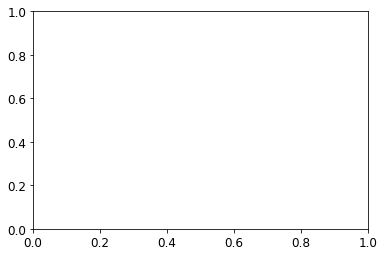

In [250]:
#Data Slicing

def acute_changes(df, metric, axis_label):
    df_new = df
    df_new = df_new[df_new['BC_Dissimilarity'].notna()]

    threshold = df_new["Impact load sustained 0-24 hours prior"].quantile(0.75)
    df_new["Sustained_Impact"] = np.where(df_new["Impact load sustained 0-24 hours prior"]> threshold, 1,0)
    
    #threshold = df_new["IMPACT.LOAD.2.24.HOURS.BEFORE.FECAL.SAMPLE"].quantile(0.75)
    #df_new["Sustained_Impact"] = np.where(df_new["IMPACT.LOAD.2.24.HOURS.BEFORE.FECAL.SAMPLE"]> threshold, 1,0)



    global data_slices
    data_slices = pd.DataFrame(columns=["Day of Impact", "1 day after", "2 days after", "3 days after", "Player"])

    df_new.groupby("Player").apply(lambda df: slice_data(df, metric))


    data_slices_long = data_slices
    data_slices_long["ID"] = data_slices_long.index.values
    data_slices_long = pd.melt(data_slices_long, value_vars=["Day of Impact", "1 day after", "2 days after", "3 days after"],
    var_name="Time", id_vars= ["ID", "Player"], value_name="Value")    
    data_slices_long['Player'] = data_slices_long['Player'].astype(str)

    print(data_slices_long)
    
    boxplot = sns.boxplot(x='Time',y='Value',data=data_slices_long, color = "white", palette="Greys", width=0.6,showfliers = False)
    boxplot = sns.stripplot(x='Time',y='Value',hue='Player',data=data_slices_long, s= 6, jitter =False)
    boxplot = sns.lineplot(
    data=data_slices_long, x="Time", y="Value", units="ID",sort =False,
    color=".6", estimator=None,alpha=0.7
    )
    boxplot.set_xlabel("Hours since Head Impact",fontsize=15)
    
    boxplot.set_xticklabels(["0-24", "24-48", "48-72", "72-96"])

    boxplot.set_ylabel(axis_label, fontsize=15)
    plt.locator_params(axis='y', nbins=4)
    boxplot.xaxis.set_tick_params(labelsize=12)
    boxplot.yaxis.set_tick_params(labelsize=12)
    
    handles, previous_labels = boxplot.get_legend_handles_labels()
    
    lgd = plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0, title = "Player",
    fontsize="12",handles=handles, labels=["1","4", "5", "8", "9"])
    lgd.get_title().set_fontsize('15') 
    boxplot.figure.savefig("../Figures/" + metric + ".png", dpi = 300, bbox_inches = "tight")  
    plt.cla() 
    #print(data_slices)
    #print(data_slices)
    (stat, p) = stats.friedmanchisquare(data_slices["Day of Impact"],
     data_slices["1 day after"], data_slices["2 days after"],
     data_slices["3 days after"])
    with open("../acute_results/" + metric + ".txt", "w") as f:
        print(stat, file= f)
        print(p, file = f)
        print(scikit_posthocs.posthoc_nemenyi_friedman(data_slices.loc[:,["Day of Impact", "1 day after", "2 days after", "3 days after"]]), file = f)

def slice_data(df, metric):

    for i in range(1, (df.shape[0]-3)):
        
        if (df.at[df.index.values[i], "Sustained_Impact"] == 1) & (df.at[df.index.values[i-1], "Sustained_Impact"] == 0):
            #check if days are continuous
            range_dates = [*range(int(df.index.values[i-1].split(".")[1]), int(df.index.values[i-1].split(".")[1])+5 )]
            #print(range_dates)
            actual_dates = [int(k.split(".")[1]) for k in df.index.values[i-1:i+4]]
            #print(actual_dates)
            if np.array_equal(range_dates, actual_dates):
            #if True:
                
                #check for no impacts in i+1, i+2, i+3, i+4, i+5 days
                if max(df.loc[df.index.values[i+1:i+4], 'Sustained_Impact'] ==0):
                    
                    Player = df.index.values[0].split(".")[0]
                    #values_to_add = [ df.at[df.index.values[i-1], "simpson"],
                    #    (df.at[df.index.values[i+1], "simpson"] +df.at[df.index.values[i+2], "simpson"])/2,
                    #    ((df.at[df.index.values[i+3], "simpson"] +df.at[df.index.values[i+4], "simpson"])/2),
                    #    df.at[df.index.values[i+5], "simpson"] ]
                    values_to_add = [ df.at[df.index.values[i], metric],
                        df.at[df.index.values[i+1], metric],df.at[df.index.values[i+2], metric],
                        df.at[df.index.values[i+3], metric] , Player]
                    data_slices.loc[len(data_slices.index)] = values_to_add

#print(alpha_master_data)
acute_changes(alpha_master_data, metric="BC_Dissimilarity", axis_label="Bray Curtis Dissimilarity")
acute_changes(alpha_master_data, metric="faith_pd", axis_label="Faith's Phylogenetic Diversity")
acute_changes(alpha_master_data, metric="simpson", axis_label="Simpson's Diversity")
acute_changes(alpha_master_data, metric="UniFrac_Distance", axis_label="Unifrac Distance")


# acute_changes(df=order_master_no_9, metric = "Bacteroidales", axis_label = "Bacteroidales")
# acute_changes(df=order_master_no_9, metric = "Bifidobacteriales", axis_label = "Bifidobacteriales")
# acute_changes(df=order_master_no_9, metric = "Lactobacillales", axis_label = "Lactobacillales")
# acute_changes(df=order_master_no_9, metric = "Burkholderiales", axis_label ="Burkholderiales")
# acute_changes(df=order_master_no_9, metric = "Enterobacterales", axis_label= "Enterobacterales")
# acute_changes(df=order_master_no_9, metric = "Pseudomonadales", axis_label = "Pseudomonadales")
# acute_changes(df=order_master_no_9, metric = "Campylobacterales", axis_label = "Campylobacterales")
# acute_changes(df=order_master_no_9, metric =  "Clostridiales", axis_label =  "Clostridiales")
# acute_changes(df=order_master_no_9, metric = "Verrucomicrobiales", axis_label =  "Verrucomicrobiales")


# acute_changes(df=family_master_no_9, metric = "Micrococcaceae", axis_label = "Micrococcaceae")
# acute_changes(df=family_master_no_9, metric = "Prevotellaceae", axis_label = "Prevotellaceae")
# acute_changes(df=family_master_no_9, metric = "Leuconostocaceae", axis_label = "Leuconostocaceae")
# acute_changes(df=family_master_no_9, metric = "Streptococcaceae", axis_label = "Streptococcaceae")
# acute_changes(df=family_master_no_9, metric = "Peptococcaceae", axis_label = "Peptococcaceae")
# acute_changes(df=family_master_no_9, metric = "Lachnospiraceae", axis_label= "Lachnospiraceae")
# acute_changes(df=family_master_no_9, metric = "Bacteroidaceae", axis_label = "Bacteroidaceae")
# acute_changes(df=family_master_no_9, metric = "Rikenellaceae", axis_label = "Rikenellaceae")
# acute_changes(df=family_master_no_9, metric = "Ruminococcaceae", axis_label = "Ruminococcaceae")
# acute_changes(df=family_master_no_9, metric = "Clostridiaceae", axis_label = "Clostridiaceae")
# acute_changes(df=family_master_no_9, metric = "Bifidobacteriaceae", axis_label ="Bifidobacteriaceae")

# acute_changes(df=genus_master_no_9, metric = "Prevotella", axis_label = "Prevotella")
# acute_changes(df=genus_master_no_9, metric = "Weissella", axis_label = "Weissella")
# acute_changes(df=genus_master_no_9, metric = "Lactococcus", axis_label = "Lactococcus")
# acute_changes(df=genus_master_no_9, metric = "Anaerostipes", axis_label = "Anaerostipes")
# acute_changes(df=genus_master_no_9, metric = "Lactobacillus", axis_label = "Lactobacillus")
# acute_changes(df=genus_master_no_9, metric = "Ruminococcus", axis_label = "Ruminococcus")
# acute_changes(df=genus_master_no_9, metric = "Bifidobacterium", axis_label = "Bifidobacterium")
# acute_changes(df=genus_master_no_9, metric = "Bacteroides", axis_label = "Bacteroides")

# acute_changes(df=species_master_no_9, metric = "Anaerostipes_hadrus", axis_label = "Anaerostipes_hadrus")


# Pre Mid Post Analysis

         Pre       Mid      Post Player
3   0.389631  0.501608  0.472666     01
4   0.337004  0.360398  0.422894     01
5   0.461837  0.354922  0.451513     01
6   0.229380  0.426920  0.362484     04
7   0.271135  0.320549  0.333628     04
8   0.268364  0.348748  0.350524     04
9   0.203087  0.329335  0.328755     05
10  0.293230  0.404449  0.342203     05
11  0.308613  0.323907  0.324132     05
12  0.242630  0.279798  0.287616     08
13  0.268515  0.323298  0.356320     08
14  0.266565  0.312442  0.351198     08
15  0.254922  0.352110  0.392769     09
16  0.337329  0.322823  0.347073     09
17  0.288919  0.481162  0.302766     09
18  0.195672  0.279802  0.441742     16
19  0.301969  0.346126  0.453547     16
20  0.561987  0.252232  0.317027     16
    ID Player  Time     Value
0    3     01   Pre  0.389631
1    4     01   Pre  0.337004
2    5     01   Pre  0.461837
3    6     04   Pre  0.229380
4    7     04   Pre  0.271135
5    8     04   Pre  0.268364
6    9     05   Pre  0.203087


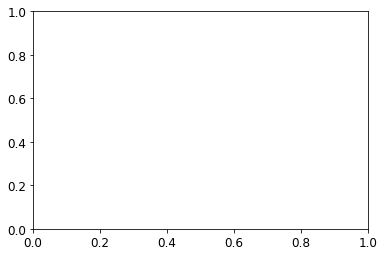

In [172]:
# Pre Mid Post Analysis
def perform_pmp(dataset, colname, axislabel, skip_first = True):

    global pre_mid_post
    pre_mid_post = pd.DataFrame(columns=["Pre", "Mid", "Post", "Player"])
    dataset.loc[:,[colname, "Player"] ].groupby("Player").apply(lambda x: find_pre_mid_post(x, colname, skip_first) )

    pre_mid_post = pre_mid_post.loc[3:,["Pre", "Mid", "Post", "Player"]]
    print(pre_mid_post)
    
    pre_mid_post_long = pre_mid_post
    pre_mid_post_long["ID"] = pre_mid_post_long.index.values
    pre_mid_post_long = pd.melt(pre_mid_post_long, value_vars=["Pre","Mid","Post"],
    var_name="Time", id_vars= ["ID", "Player"], value_name="Value")    
    print(pre_mid_post_long)
    pre_mid_post_long['Player'] = pre_mid_post_long['Player'].astype(str)
    boxplot = sns.boxplot(x='Time',y='Value',data=pre_mid_post_long, palette="Greys", width=0.5, showfliers=False)
    boxplot = sns.stripplot(x='Time',y='Value',hue='Player',data=pre_mid_post_long, s= 6, jitter =False)
    boxplot = sns.lineplot(
    data=pre_mid_post_long, x="Time", y="Value", units="ID",sort =False,
    color=".7", estimator=None,alpha=0.7
    )
    boxplot.set_xlabel("Collection Period",fontsize=15)
    
    boxplot.set_xticklabels(["Early", "Middle", "Late"])

    boxplot.set_ylabel(axislabel, fontsize=15)
    plt.locator_params(axis='y', nbins=4)
    boxplot.xaxis.set_tick_params(labelsize=12)
    boxplot.yaxis.set_tick_params(labelsize=12)
    handles, previous_labels = boxplot.get_legend_handles_labels()

    lgd = plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0, title = "Player",
    fontsize="12", handles = handles, labels = ["1","4","5","8","9","16"])
    lgd.get_title().set_fontsize('15') 
    boxplot.figure.savefig("../PreMidPost_Figures/" + colname + "_pre_mid_post.png", dpi =300, bbox_inches = "tight")
    plt.cla()
    #(stat, p) = stats.kruskal(pre_mid_post_BC["Pre"], pre_mid_post_BC["Mid"],pre_mid_post_BC["Post"])
    #print(stat)
    #print(p)
    with open("../PreMidPost/" + colname + ".txt", "w") as f:
        (stat, p) = stats.friedmanchisquare( pre_mid_post["Pre"], pre_mid_post["Mid"],pre_mid_post["Post"])
        print(stat, file =f)
        print(p, file = f)

        print(scikit_posthocs.posthoc_nemenyi_friedman(pre_mid_post.loc[:, ["Pre", "Mid", "Post"]]), file =f)


def find_pre_mid_post(df, colname, skip_first):
    nrows = df.shape[0]
    center = math.floor(nrows/2)
    #pre_mid_post.loc[len(pre_mid_post)] = [df.loc[df.index.values[1:4], colname].mean(), df.loc[df.index.values[center-1:center+2], colname].mean(),df.loc[df.index.values[nrows-3:nrows], colname].mean()]
    #pre_mid_post_BC.loc[len(pre_mid_post_BC)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-4], colname]]
    Player = df.index.values[0].split(".")[0]
    if skip_first:
        if (df.index.values[0].startswith("01.")| df.index.values[0].startswith("04.")):
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-5], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-4], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[3], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-3], colname], Player]
        
        else:
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-3], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-2], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[3], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-1], colname], Player]
    else:
        if (df.index.values[0].startswith("01.")| df.index.values[0].startswith("04.")):
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-5], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-4], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-3], colname], Player]
        
        else:
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-3], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-2], colname], Player]
            pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-1], colname], Player]

perform_pmp(alpha_master_data, "BC_Dissimilarity", "Bray Curtis Dissimilarity", True)

perform_pmp(alpha_master_data, "faith_pd", "Faith's Phylogenetic Diversity", True)


# acute_changes(df=order_master_no_9, metric = "Bacteroidales", axis_label = "Bacteroidales")
# acute_changes(df=order_master_no_9, metric = "Bifidobacteriales", axis_label = "Bifidobacteriales")
# acute_changes(df=order_master_no_9, metric = "Lactobacillales", axis_label = "Lactobacillales")
##perform_pmp(order_master_no_9, "Coriobacteriales", "Coriobacteriales", False)

##perform_pmp(order_master_no_9, "Burkholderiales",  "Burkholderiales", False)
# acute_changes(df=order_master_no_9, metric = "Enterobacterales", axis_label= "Enterobacterales")
# acute_changes(df=order_master_no_9, metric = "Pseudomonadales", axis_label = "Pseudomonadales")
# acute_changes(df=order_master_no_9, metric = "Campylobacterales", axis_label = "Campylobacterales")
# acute_changes(df=order_master_no_9, metric =  "Clostridiales", axis_label =  "Clostridiales")
# acute_changes(df=order_master_no_9, metric = "Verrucomicrobiales", axis_label =  "Verrucomicrobiales")


# acute_changes(df=family_master_no_9, metric = "Micrococcaceae", axis_label = "Micrococcaceae")
##perform_pmp(family_master_no_9, "Prevotellaceae", "Prevotellaceae", False)
# acute_changes(df=family_master_no_9, metric = "Leuconostocaceae", axis_label = "Leuconostocaceae")
# acute_changes(df=family_master_no_9, metric = "Streptococcaceae", axis_label = "Streptococcaceae")
##perform_pmp(family_master_no_9, "Peptococcaceae",  "Peptococcaceae", False)
##perform_pmp(family_master_no_9, "Lachnospiraceae", "Lachnospiraceae", False)
# acute_changes(df=family_master_no_9, metric = "Bacteroidaceae", axis_label = "Bacteroidaceae")
# acute_changes(df=family_master_no_9, metric = "Rikenellaceae", axis_label = "Rikenellaceae")
##perform_pmp(family_master_no_9,  "Ruminococcaceae", "Ruminococcaceae")
# acute_changes(df=family_master_no_9, metric = "Clostridiaceae", axis_label = "Clostridiaceae")
# acute_changes(df=family_master_no_9, metric = "Bifidobacteriaceae", axis_label ="Bifidobacteriaceae")

##perform_pmp(genus_master_no_9, "Prevotella", "Prevotella", False)
##perform_pmp(genus_master_no_9,  "Weissella", "Weissella", False)
# acute_changes(df=genus_master_no_9, metric = "Lactococcus", axis_label = "Lactococcus")
# acute_changes(df=genus_master_no_9, metric = "Anaerostipes", axis_label = "Anaerostipes")
# acute_changes(df=genus_master_no_9, metric = "Lactobacillus", axis_label = "Lactobacillus")
##perform_pmp(genus_master_no_9,  "Ruminococcus",  "Ruminococcus", False)
# acute_changes(df=genus_master_no_9, metric = "Bifidobacterium", axis_label = "Bifidobacterium")
# acute_changes(df=genus_master_no_9, metric = "Bacteroides", axis_label = "Bacteroides")


# Phyla Level Analysis

In [223]:
phyla_table = pd.read_csv("phyla-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
phyla_table = phyla_table.T
phyla_table.index.names = ["Sample_ID"]
#phyla_table.drop(phyla_table.tail(5).index,inplace=True) # drop last n rows
for i in range(phyla_table.shape[1]):
    column_name = phyla_table.columns[i]
    if "p__" in column_name:
        phyla_table.rename(columns = {column_name:column_name.split("p__", 1)[1]}, inplace= True)

phyla_table.loc["09.0808"] = (phyla_table.loc["09.0808.1"] + phyla_table.loc["09.0808.2"]) /2
phyla_table.rename(columns={'d__Bacteria;__': 'Unclassified'}, inplace=True)
phyla_table.to_csv("../phyla_processed_with_control.tsv", sep ="\t")



In [271]:
phyla = sorted(phyla_table.columns.values.tolist())
print(phyla)
phyla_master_no_9 = pd.read_csv("../phyla_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
phyla_master_no_9 = phyla_master_no_9.set_index(phyla_master_no_9.columns[0])

pre_phyla = pd.DataFrame(columns=np.append(phyla, ["Player"]))

mid_phyla = pd.DataFrame(columns=np.append(phyla, ["Player"]))
post_phyla = pd.DataFrame(columns=np.append(phyla, ["Player"]))
def find_pre_mid_post_phyla(df, list_of_phyla):
    global pre_phyla
    global mid_phyla
    global post_phyla
    nrows = df.shape[0]
    center = math.floor(nrows/2)
    Player = df.index.values[0].split(".")[0]
    if (df.index.values[0].startswith("01.")| df.index.values[0].startswith("04.")):
        pre_phyla = pre_phyla.append(pd.DataFrame(df.loc[df.index.values[1:4],phyla].mean()).T.assign(Player = Player), ignore_index=True)
        mid_phyla = mid_phyla.append(pd.DataFrame(df.loc[df.index.values[center-1:center+2],phyla].mean()).T.assign(Player=Player), ignore_index=True)
        post_phyla = post_phyla.append(pd.DataFrame(df.loc[df.index.values[nrows-5:nrows-2],phyla].mean()).T.assign(Player = Player), ignore_index=True)
    else:
        pre_phyla = pre_phyla.append(pd.DataFrame(df.loc[df.index.values[1:4],phyla].mean()).T.assign(Player = Player), ignore_index=True)
        mid_phyla = mid_phyla.append(pd.DataFrame(df.loc[df.index.values[center-1:center+2],phyla].mean()).T.assign(Player=Player), ignore_index=True)
        post_phyla = post_phyla.append(pd.DataFrame(df.loc[df.index.values[nrows-3:nrows],phyla].mean()).T.assign(Player = Player), ignore_index=True)
    
    
phyla_master_no_9.groupby("Player").apply(lambda x: find_pre_mid_post_phyla(x, phyla) )

find_pre_mid_post_phyla(phyla_master_no_9, phyla)

pre_phyla.drop(index = pre_phyla.head(1).index,inplace=True) 
pre_phyla.drop(index = pre_phyla.tail(1).index,inplace=True) 
mid_phyla.drop(index=mid_phyla.head(1).index,inplace=True)
mid_phyla.drop(index = mid_phyla.tail(1).index,inplace=True)
post_phyla.drop(index =post_phyla.head(1).index,inplace=True) 
post_phyla.drop(index =post_phyla.tail(1).index,inplace=True) 

fig, ax = plt.subplots(3,6)

for i,time in enumerate(["Pre", "Mid", "Post"]):
    player_title = ["1", "4", "5", "8", "9", "16"]
    time_label = ["Early", "Middle", "Late"]
    for j, Player in enumerate(["01", "04", "05", "08", "09", "16"]):
        
        if time == "Pre":
            fracs = pre_phyla.loc[pre_phyla['Player'] == Player, phyla]
        elif time == "Mid":
            fracs = mid_phyla.loc[mid_phyla['Player'] == Player, phyla]
        else:
            fracs = post_phyla.loc[post_phyla['Player'] == Player, phyla]
            ax[i, j].text(0.5, -0.2, player_title[j], transform=ax[i, j].transAxes,
                      horizontalalignment='center', verticalalignment='center',
                      fontsize =15)
            #ax[i,j].set_title(player_title[j], y=-0.01)
        ax[i,j].pie(fracs, labels=None,
            autopct=None, shadow=False, startangle=90,
            colors=["blue","orange","red", "cyan","pink","purple","green","grey","brown"])
        ax[i,j].set_aspect('equal')
            # label y axis
        if ax[i,j].is_first_col():
            ax[i,j].set_ylabel(time_label[i], fontsize = 15, rotation = 0,labelpad=18)
        

fig.text(0.55, -0.01, "Player", ha="center", fontsize=15)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

lgd = fig.legend(phyla, loc = 'center right',bbox_to_anchor=(1.3, 0.5))
fig.savefig("../PreMidPost_Figures/PreMidPost_phyla.png", dpi = 300, bbox_inches = "tight")
plt.close()

### Stacked Bar Plot
fig, ax = plt.subplots(3,1, sharex = True)

for i,time in enumerate(["Early", "Middle", "Late"]):
    if time == "Early":
        fracs = pre_phyla
    elif time == "Middle":
        fracs = mid_phyla
    else:
        fracs = post_phyla
    fracs.plot.bar(x = "Player", stacked = True, ax=ax[i], legend = False,
     color=["blue","orange","red", "cyan","pink","purple","green","grey","brown"])
   
    ax[i].set_title(time, fontsize = 15, loc='left')
    ax[i].yaxis.set_tick_params(labelsize=12)
ax[1].set_ylabel('Relative Abundance', fontsize = 15)

ax[2].set_xlabel("Player", fontsize =15)
ax[2].set_xticklabels(["1", "4", "5", "8", "9", "16"], rotation = 0, fontsize =12)
plt.tight_layout(pad=0.4, w_pad=0.6, h_pad=1.0)
plt.subplots_adjust(wspace=0, hspace=0.5)

lgd = fig.legend(phyla, loc = 'center right',bbox_to_anchor=(1.3, 0.5), borderaxespad = 0., title= 'Phyla')
lgd.get_title().set_fontsize('15') 
fig.savefig("../PreMidPost_Figures/PreMidPost_phyla_bar.png", dpi = 300, bbox_inches = "tight")
plt.close()



        # Adding metadata for PDF file
        

['Actinobacteriota', 'Bacteroidota', 'Campilobacterota', 'Desulfobacterota', 'Euryarchaeota', 'Firmicutes', 'Proteobacteria', 'Unclassified', 'Verrucomicrobiota']


In [249]:
phyla_master_no_9_control = pd.read_csv("../phyla_master_without_9_with_control.tsv", sep ="\t", dtype={"Sample_ID":"str"})
phyla_master_no_9_control = phyla_master_no_9_control.set_index(phyla_master_no_9_control.columns[0])

phyla_master_no_9_control_players = phyla_master_no_9_control.drop(
    phyla_master_no_9_control.tail(5).index) # drop last n rows

phyla_master_no_9_control_players["Player"] = [i.split(".")[0] for i in phyla_master_no_9_control_players.index.tolist()]


first_data_points = phyla_master_no_9_control_players.groupby("Player").first().reset_index().loc[:,np.append(phyla, ["Player"])]
controls = phyla_master_no_9_control.tail(5)
controls.sort_index(axis=1, inplace=True)
controls["Player"] = controls.index.values
print(controls)

fig, ax = plt.subplots(1,2, sharey = True)


first_data_points.plot.bar(x = "Player", stacked = True, ax=ax[0], legend = False,
    color=["blue","orange","red", "brown","pink","purple","green","grey","cyan"])
controls.plot.bar(x = "Player", stacked = True, ax=ax[1], legend = False,
    color=["blue","orange","red", "brown","pink","purple","green","grey","cyan"])
ax[0].set_ylabel('Relative Abundance', fontsize = 15)
ax[0].set_xlabel("Player", fontsize =15)
ax[1].set_xlabel("Control Samples", fontsize =15)
ax[0].set_xticklabels(["1", "4", "5", "8", "9", "16"], rotation = 0, fontsize =12)
ax[1].set_xticklabels(["Mock", "N1", "N2", "P1", "P2"], rotation = 0, fontsize =12)
ax[0].yaxis.set_tick_params(labelsize=12)
plt.tight_layout(pad=0.4, w_pad=0.6, h_pad=1.0)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.locator_params(axis='y', nbins=3)
lgd = fig.legend(phyla, loc = 'center right',bbox_to_anchor=(1.3, 0.5), borderaxespad = 0., title= 'Phyla')
lgd.get_title().set_fontsize('15') 
fig.savefig("../PreMidPost_Figures/Control_Bar.png", dpi = 300, bbox_inches = "tight")
plt.close()



               Actinobacteriota  Bacteroidota  Campilobacterota  \
Sample_ID                                                         
Internal.Mock          0.009188      0.000000               0.0   
NEG.CONT.E             0.034169      0.276885               0.0   
NEG.CONT.NE            0.250857      0.072000               0.0   
POS.CONT.1             0.000000      0.000000               0.0   
POS.CONT.2             0.000000      0.000000               0.0   

               Desulfobacterota  Euryarchaeota  Firmicutes  Proteobacteria  \
Sample_ID                                                                    
Internal.Mock          0.000000            0.0    0.288864        0.701948   
NEG.CONT.E             0.000971            0.0    0.651510        0.036465   
NEG.CONT.NE            0.000000            0.0    0.431714        0.245429   
POS.CONT.1             0.000000            0.0    0.000000        1.000000   
POS.CONT.2             0.000000            0.0    0.000000    

In [107]:
phyla = phyla_table.columns
phyla_master_no_9 = pd.read_csv("../phyla_master_without_9.tsv", sep ="\t", dtype={"Sample_ID":"str"})
phyla_master_no_9 = phyla_master_no_9.set_index(phyla_master_no_9.columns[0])

pre_mid_post_phyla = pd.DataFrame(columns=["Pre", "Mid", "Post", "Player", "Phyla"])
phyla_master_no_9.loc[:,[phyla, "Player"] ].groupby("Player").apply(lambda x: find_pre_mid_post(x, colname, skip_first) )

pre_mid_post = pre_mid_post.loc[3:,["Pre", "Mid", "Post", "Player", "Phyla"]]
    
    pre_mid_post_long = pre_mid_post
    pre_mid_post_long["ID"] = pre_mid_post_long.index.values
    pre_mid_post_long = pd.melt(pre_mid_post_long, value_vars=["Pre","Mid","Post"],
    var_name="Time", id_vars= ["ID", "Player"], value_name="Value")    
    print(pre_mid_post_long)
    pre_mid_post_long['Player'] = pre_mid_post_long['Player'].astype(str)

    


def find_pre_mid_post(df, colname, skip_first):
    nrows = df.shape[0]
    center = math.floor(nrows/2)
    #pre_mid_post.loc[len(pre_mid_post)] = [df.loc[df.index.values[1:4], colname].mean(), df.loc[df.index.values[center-1:center+2], colname].mean(),df.loc[df.index.values[nrows-3:nrows], colname].mean()]
    #pre_mid_post_BC.loc[len(pre_mid_post_BC)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-4], colname]]
    Player = df.index.values[0].split(".")[0]
    
    
    if (df.index.values[0].startswith("01.")| df.index.values[0].startswith("04.")):
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-5], colname], Player]
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-4], colname], Player]
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-3], colname], Player]
    
    else:
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-3], colname], Player]
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-2], colname], Player]
        pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-1], colname], Player]


IndentationError: unexpected indent (<ipython-input-107-f0a680e5bf46>, line 10)

In [ ]:
pre_mid_post = pd.DataFrame(columns=["Pre", "Mid", "Post"])

def find_pre_mid_post(df, colname):
    global pre_mid_post
    nrows = df.shape[0]
    center = math.floor(nrows/2)
    #pre_mid_post.loc[len(pre_mid_post)] = [df.loc[df.index.values[1:4], colname].mean(), df.loc[df.index.values[center-1:center+2], colname].mean(),df.loc[df.index.values[nrows-3:nrows], colname].mean()]
    pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[0], colname], df.at[df.index.values[center-1], colname],df.at[df.index.values[nrows-4], colname]]
    pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[1], colname], df.at[df.index.values[center], colname],df.at[df.index.values[nrows-3], colname]]
    pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[2], colname], df.at[df.index.values[center+1], colname],df.at[df.index.values[nrows-2], colname]]
    pre_mid_post.loc[len(pre_mid_post)] = [df.at[df.index.values[3], colname], df.at[df.index.values[center+2], colname],df.at[df.index.values[nrows-1], colname]]

#print(alpha_diversity_master_dummy)
alpha_diversity_master_dummy.loc[:,["faith_pd", "Player"] ].groupby("Player").apply(lambda x: find_pre_mid_post(x, "faith_pd") )

pre_mid_post = pre_mid_post.loc[4:,["Pre", "Mid", "Post"]]
print(pre_mid_post)

pre_mid_post.boxplot().figure.savefig("alpha_pre_mid_post.png", dpi =300, bbox_inches="tight")
(stat, p) = stats.f_oneway(pre_mid_post["Pre"], pre_mid_post["Mid"],pre_mid_post["Post"])
print(stat)
print(p)

(stat, p) = stats.friedmanchisquare( pre_mid_post["Pre"], pre_mid_post["Mid"],pre_mid_post["Post"])
print(stat)
print(p)

print(stats.wilcoxon(pre_mid_post["Pre"], pre_mid_post["Post"]))


# Metabolomics Analysis

In [ ]:
%%bash
../FAPROTAX_1.2.6/collapse_table.py \
    -i species-table/feature-table.biom \
    -o func_table.tsv \
    -g ../FAPROTAX_1.2.6/FAPROTAX.txt -v


In [260]:
func_table = pd.read_csv("func_table.tsv", sep = "\t", index_col = 0)
func_table = func_table.T
func_table.index.names = ["Sample_ID"]
func_table.drop(func_table.tail(5).index,inplace=True) # drop last n rows
func_table.loc["09.0808"] = (func_table.loc["09.0808.1"] + func_table.loc["09.0808.2"]) /2

func_table.to_csv("../func_processed.tsv",sep ="\t")

In [ ]:
order_table = pd.read_csv("order-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
order_table = order_table.T

#order_table = order_table.rename(index = {'#OTU ID':'Sample_ID'})
order_table.index.names = ["Sample_ID"]
order_table.drop(order_table.tail(5).index,inplace=True) # drop last n rows
for i in range(order_table.shape[1]):
    column_name = order_table.columns[i]
    if "o__" in column_name:
        order_table.rename(columns = {column_name:column_name.split("o__", 1)[1]}, inplace= True)
#print(order_table)

order_table_01 = order_table[order_table.index.str.startswith("01.")]
first_row = np.array(order_table_01.iloc[0])

#print(first_row)
upper_quantile = np.quantile(first_row, 0.75)
#print(upper_quantile)

above_threshold = first_row > upper_quantile
above_threshold = np.array(above_threshold)
#above_threshold = np.insert(above_threshold,0, True)
#print(above_threshold)

order_table_01 = order_table_01.loc[:, np.array(above_threshold)]
#print(order_table_01)

head_impact_data = pd.read_csv("../Master Spreadsheet - Master Data Sheet.csv", dtype={"Sample_ID": "str"}) 

head_impact_data = head_impact_data.iloc[:, [0,2]]
head_impact_data = head_impact_data.set_index(head_impact_data.columns[0])

head_impact_data_01 = head_impact_data[head_impact_data.index.str.startswith("01.")]

ax = order_table_01.plot.bar(stacked = True)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 4.2)
ax.xaxis.set_tick_params(labelsize = 3.8)
ax.figure.savefig("Order_Barplot_01.png",bbox_inches='tight',dpi=300)

ax2 = head_impact_data_01.plot.bar()
ax2.xaxis.set_tick_params(labelsize=3.1)
ax2.yaxis.set_tick_params(labelsize= 4)
ax2.get_legend().remove()
ax2.figure.savefig("HI_01.png",bbox_inches='tight',dpi=300)


merged_data = order_table_01.combine_first(head_impact_data_01)
#print(merged_data)
merged_data.drop(labels = "Impact Load (ROUGH)", axis = 1, inplace=True)
ax3 = merged_data.plot(subplots=True, sharex = True, figsize=(24,16))

x = merged_data.index
print(x)
plt.xticks(np.arange(len(x)), x, rotation =90)
for ax_ in ax3:
    ax_.yaxis.set_tick_params(labelsize = 8)
    ax_.legend(loc = "upper left")
    ax_addon = ax_.twinx()
    ax_addon.bar(x, head_impact_data_01['Impact Load (ROUGH)'], color="blue", alpha=0.5)
    ax_addon.tick_params(axis='y', colors="blue")

    
ax3[0].figure.savefig("Lineplots_Order_01.png",bbox_inches='tight',dpi=300)




In [ ]:
order_table = pd.read_csv("order-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
order_table = order_table.T

#order_table = order_table.rename(index = {'#OTU ID':'Sample_ID'})
order_table.index.names = ["Sample_ID"]
order_table.drop(order_table.tail(5).index,inplace=True) # drop last n rows
for i in range(order_table.shape[1]):
    column_name = order_table.columns[i]
    if "o__" in column_name:
        order_table.rename(columns = {column_name:column_name.split("o__", 1)[1]}, inplace= True)

#print(order_table)
orders = order_table.columns
#order_table = order_table.add(1)
order_table["Player"] = [i.split(".")[0] for i in order_table.index.tolist()]
#print(order_table)
order_table_pct = order_table.groupby("Player").apply(lambda x: x.add(0.01).pct_change())
order_table_pct.reset_index(inplace =True)
order_table_pct.index = order_table.index
order_table_pct.fillna(0, inplace=True)
print(order_table_pct)
#order_table = order_table.groupby("Player").apply(lambda x: x.div(x.iloc[0].add(0.01)))
#order_table_pct["Player"] = [i.split(".")[0] for i in order_table_pct.index.tolist()]
#print(order_table_pct)
#order_table = order_table.groupby("Player").apply(lambda x: x.shift(-3))
#order_table["Player"] = [i.split(".")[0] for i in order_table.index.tolist()]

master_data = pd.read_csv("../Master Spreadsheet - Master Data Sheet.tsv", dtype={"Sample_ID": "str"},
    sep = "\t") 
master_data = master_data.set_index(master_data.columns[0])
order_master = order_table_pct.combine_first(master_data)

order_master = order_master.dropna()

order_master.drop("Fecal Sample Before or After Practice/Game?", axis = 1, inplace= True)
columns_to_dummify = ["Orthopedic Injury", "Vomitted","Bristol Stool Scale", 
    "Stool Color", "Self-Reported Illness", "Fiber", "Fiber Supplements", "Red Meat", "Refined Carbohydrates and Sugar",
    "NSAIDS","Caffeine", "Nicotine Products", "Cannabis", "Pro-biotics", "Creatine",
    "Pre-Workout", "Multi-vitamin", "Fish Oil", "Vitamin D", "Collagen", "Prescription Medications",
    "Change of Living or Dining Circumstance"]
dummy_columns = pd.get_dummies(order_master[columns_to_dummify], columns= columns_to_dummify,drop_first=True)
order_master.drop(columns_to_dummify, axis = 1, inplace= True)
order_master_dummy = pd.concat([order_master,dummy_columns], axis=1)

order_master_dummy.columns = order_master_dummy.columns.str.replace(' ', '_')
order_master_dummy.columns = order_master_dummy.columns.str.replace('-', '_')
order_master_dummy.columns = order_master_dummy.columns.str.replace('/', '_')
order_master_dummy.columns = order_master_dummy.columns.str.replace('(', '')
order_master_dummy.columns = order_master_dummy.columns.str.replace(')', '')
order_master_dummy.columns = order_master_dummy.columns.str.replace('?', '')
order_master_dummy.columns = order_master_dummy.columns.str.replace('.0', '')
order_master_dummy.to_csv("order_master_processed.csv")

# print(order_master_dummy[order_master_dummy["Player"]!="16"])
# model = smf.mixedlm(formula = "Enterobacterales ~  Impact_Load_ROUGH", data = order_master_dummy, groups = 'Player').fit()
# print(model.summary())

# model = smf.mixedlm(formula = "Bifidobacteriales ~  Impact_Load_ROUGH", data = order_master_dummy[order_master_dummy["Player"]!="16"], groups = 'Player').fit()
# print(model.summary())

# model = smf.mixedlm(formula = "Lachnospirales ~  Impact_Load_ROUGH", data = order_master_dummy, groups = 'Player').fit()
# print(model.summary())

# model = smf.ols("Bacteroidales ~ Impact_Load_ROUGH", data = order_master_dummy[order_master_dummy.index.str.startswith("01.")]).fit()
# print(model.summary())

# model = smf.mixedlm(formula = "Coriobacteriales ~ Impact_Load_ROUGH", data = order_master_dummy, groups = 'Player').fit()
# print(model.summary())
#with open("Corio_LM.txt", "w") as f:
#    print(model.summary(), file = f)
model = smf.mixedlm(formula = "Coriobacteriales ~Orthopedic_Injury_1+ Orthopedic_Injury_2+  Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy, groups = 'Player').fit()
with open("Corio_LM.txt", "w") as f:
    print(model.summary(), file = f)

#model = smf.ols("Coriobacteriales ~ Impact_Load_ROUGH", data = order_master_dummy[order_master_dummy.index.str.startswith("01.")]).fit()
#print(model.summary())

model = smf.mixedlm(formula = "Bifidobacteriales ~  Orthopedic_Injury_1+ Orthopedic_Injury_2+  Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy, groups = 'Player').fit()
with open("Bifi_LM.txt", "w") as f:
    print(model.summary(), file = f)



#model = smf.ols("Bifidobacteriales ~ Impact_Load_ROUGH", data = order_master_dummy[order_master_dummy.index.str.startswith("01.")]).fit()
#print(model.summary())
model = smf.mixedlm(formula = "Bifidobacteriales ~  Orthopedic_Injury_1+ Orthopedic_Injury_2+  Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy, groups = 'Player').fit()
with open("Bifi_LM.txt", "w") as f:
    print(model.summary(), file = f)

model = smf.mixedlm(formula = "Lachnospirales ~   Orthopedic_Injury_1+ Orthopedic_Injury_2+  Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy, groups = 'Player').fit()
with open("Lach_LM.txt", "w") as f:
    print(model.summary(), file = f)

model = smf.mixedlm(formula = "Bacteroidales  ~Orthopedic_Injury_1+ Orthopedic_Injury_2+  Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy, groups = 'Player').fit()
with open("Bacteroidales_LM.txt", "w") as f:
    print(model.summary(), file = f)


In [ ]:
print(order_master_dummy.loc[:,orders])
corr_mat = order_master_dummy.loc[:,orders].corr()
print(corr_mat)
lower_tri = np.tril(corr_mat)
cmap = sns.diverging_palette(250, 10, center='light',as_cmap=True)
vmax = np.abs(corr_mat).max()
print("VMAX",vmax)
ax = sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns,
        mask = lower_tri,vmax=vmax, vmin= -vmax,
        cmap = cmap)
ax.xaxis.set_tick_params(labelsize = 5)
ax.yaxis.set_tick_params(labelsize = 5)
ax.get_figure().savefig("Corr_Map_Order_all.png",bbox_inches='tight',dpi=300)
plt.clf()

In [ ]:
model = smf.ols("Coriobacteriales ~ Impact_Load_ROUGH+Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3 + Blood_In_Stool + Bristol_Stool_Scale_1 + Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 + Bristol_Stool_Scale_4 + Bristol_Stool_Scale_6 + Bristol_Stool_Scale_7", data = order_master_dummy[order_master_dummy.index.str.startswith("01.")]).fit()
print(model.summary())

In [ ]:
genus_table = pd.read_csv("genus-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
genus_table = genus_table.T

#order_table = order_table.rename(index = {'#OTU ID':'Sample_ID'})
genus_table.index.names = ["Sample_ID"]
genus_table.drop(genus_table.tail(5).index,inplace=True) # drop last n rows
for i in range(genus_table.shape[1]):
    column_name = genus_table.columns[i]
    if "g__" in column_name:
        genus_table.rename(columns = {column_name:column_name.split("g__", 1)[1]}, inplace= True)


genus_table_01 = genus_table[genus_table.index.str.startswith("01.")]
print(genus_table_01)



In [ ]:
#Alpha Diversity analysis
species_table = pd.read_csv("species-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
species_table = species_table.T

species_table.drop(species_table.tail(5).index,inplace=True) # drop last n rows
for i in range(species_table.shape[1]):
    column_name = species_table.columns[i]
    if "s__" in column_name:
        species_table.rename(columns = {column_name:column_name.split("s__", 1)[1]}, inplace= True)

print(species_table)
#####################





In [ ]:
alpha_diversity_table = pd.read_csv("species-simpson-table/alpha-diversity.tsv", sep = "\t",
    index_col=0)
alpha_diversity_table.drop(alpha_diversity_table.tail(5).index,inplace=True) # drop last n rows

alpha_diversity_table = alpha_diversity_table.combine_first(head_impact_data)
x = alpha_diversity_table.index
plt.xticks(np.arange(len(x)), x, rotation =90, fontsize = 3)
plt.plot(alpha_diversity_table["simpson"])
ax_alpha_2 = plt.twinx()
ax_alpha_2.bar(x, alpha_diversity_table["Impact Load (ROUGH)"],color="blue", alpha=0.5)
plt.savefig("alpha_barplot.png",bbox_inches='tight',dpi=300)

In [ ]:
plt.scatter(alpha_diversity_table["Impact Load (ROUGH)"], alpha_diversity_table["simpson"])

In [ ]:
alpha_diversity_table = pd.read_csv("species-simpson-table/alpha-diversity.tsv", sep = "\t",
    index_col=0)
alpha_diversity_table.drop(alpha_diversity_table.tail(5).index,inplace=True) # drop last n rows
alpha_diversity_table_01 = alpha_diversity_table[alpha_diversity_table.index.str.startswith("01.")]
alpha_diversity_table_01 = alpha_diversity_table_01.pct_change().shift(-3)
alpha_diversity_table_01 = alpha_diversity_table_01.combine_first(head_impact_data_01)

x = alpha_diversity_table_01.index
plt.xticks(np.arange(len(x)), x, rotation =90, fontsize=3)
plt.plot(alpha_diversity_table_01["simpson"])
ax_alpha_2 = plt.twinx()
ax_alpha_2.bar(x, alpha_diversity_table_01["Impact Load (ROUGH)"],color="blue", alpha=0.5)
plt.savefig("alpha_barplot_01.png",bbox_inches='tight',dpi=300)

plt.clf()

x, y = alpha_diversity_table_01["Impact Load (ROUGH)"].values, alpha_diversity_table_01["simpson"].values
nas = np.logical_or(np.isnan(x), np.isnan(y))
corr, p = stats.pearsonr(x[~nas], y[~nas])
print(corr,p)
sns.regplot(x = "Impact Load (ROUGH)",
            y = "simpson",
            data = alpha_diversity_table_01).get_figure().savefig("alpha_v_HI.png", dpi = 300, bbox_inches = "tight")



In [ ]:
alpha_diversity_table = pd.read_csv("species-faith-table/alpha-diversity.tsv", sep = "\t",
    index_col=0)
alpha_diversity_table.drop(alpha_diversity_table.tail(5).index,inplace=True) # drop last n rows
alpha_diversity_table_01 = alpha_diversity_table[alpha_diversity_table.index.str.startswith("01.")]
alpha_diversity_table_01 = alpha_diversity_table_01.pct_change()
alpha_diversity_table_01 = alpha_diversity_table_01.combine_first(head_impact_data_01)

x = alpha_diversity_table_01.index
plt.xticks(np.arange(len(x)), x, rotation =90, fontsize=3)
plt.plot(alpha_diversity_table_01["faith_pd"])
ax_alpha_2 = plt.twinx()
ax_alpha_2.bar(x, alpha_diversity_table_01["Impact Load (ROUGH)"],color="blue", alpha=0.5)
plt.savefig("alpha_barplot_01.png",bbox_inches='tight',dpi=300)

plt.clf()

x, y = alpha_diversity_table_01["Impact Load (ROUGH)"].values, alpha_diversity_table_01["faith_pd"].values
nas = np.logical_or(np.isnan(x), np.isnan(y))
corr, p = stats.pearsonr(x[~nas], y[~nas])
print(corr,p)
sns.regplot(x = "Impact Load (ROUGH)",
            y = "faith_pd",
            data = alpha_diversity_table_01).get_figure().savefig("alpha_v_HI.png", dpi = 300, bbox_inches = "tight")

In [ ]:
master_data = pd.read_csv("../Master Spreadsheet - Master Data Sheet.tsv", dtype={"Sample_ID": "str"},
    sep = "\t") 
master_data = master_data.set_index(master_data.columns[0])
alpha_diversity_table_master = alpha_diversity_table.combine_first(master_data)

alpha_diversity_table_master = alpha_diversity_table_master.dropna()

alpha_diversity_table_master.drop("Fecal Sample Before or After Practice/Game?", axis = 1, inplace= True)
columns_to_dummify = ["Orthopedic Injury", "Vomitted","Bristol Stool Scale", 
    "Stool Color", "Self-Reported Illness", "Fiber", "Fiber Supplements", "Red Meat", "Refined Carbohydrates and Sugar",
    "NSAIDS","Caffeine", "Nicotine Products", "Cannabis", "Pro-biotics", "Creatine",
    "Pre-Workout", "Multi-vitamin", "Fish Oil", "Vitamin D", "Collagen", "Prescription Medications",
    "Change of Living or Dining Circumstance"]
dummy_columns = pd.get_dummies(alpha_diversity_table_master[columns_to_dummify], columns= columns_to_dummify,drop_first=True)
alpha_diversity_table_master.drop(columns_to_dummify, axis = 1, inplace= True)
alpha_diversity_master_dummy = pd.concat([alpha_diversity_table_master,dummy_columns], axis=1)

alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace(' ', '_')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace('-', '_')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace('/', '_')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace('(', '')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace(')', '')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace('?', '')
alpha_diversity_master_dummy.columns = alpha_diversity_master_dummy.columns.str.replace('.0', '')
alpha_diversity_master_dummy.to_csv("processed_data_alpha_diversity.csv")

independent_var = list(alpha_diversity_master_dummy.columns)
independent_var.remove("faith_pd")
print(independent_var)
x = alpha_diversity_master_dummy[independent_var]
regressor = LinearRegression().fit(x, alpha_diversity_master_dummy["faith_pd"])
print('Intercept: \n', regressor.intercept_)
print('Coefficients: \n', regressor.coef_)

x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(alpha_diversity_master_dummy["faith_pd"], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
f = open("linear_model_.txt", "w")
print(print_model, file = f)
f.close()


In [ ]:
alpha_diversity_master_dummy["Player"] = [i.split(".")[0] for i in alpha_diversity_master_dummy.index.tolist()]
model = smf.mixedlm(formula = "faith_pd ~  Orthopedic_Injury_1+Orthopedic_Injury_2+Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 +Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 +Bristol_Stool_Scale_4 +Bristol_Stool_Scale_6 +Bristol_Stool_Scale_7 + Suspected_Head_Impact_off_the_Field +Suspected_Head_Impact_on_the_Field + Nicotine_Products_1+Nicotine_Products_2+Nicotine_Products_3+Nicotine_Products_4 +  Creatine_1+Creatine_2 +Change_of_Living_or_Dining_Circumstance_1+Change_of_Living_or_Dining_Circumstance_3", data = alpha_diversity_master_dummy, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_pd.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
time_shift_1 = alpha_diversity_master_dummy.loc[:, ["faith_pd", "Player"] ].groupby("Player").apply(lambda x: x.shift(-1))

time_shift_1["Impact_Load_ROUGH"] = alpha_diversity_master_dummy["Impact_Load_ROUGH"]
print(time_shift_1)
time_shift_1=time_shift_1.dropna(axis = 0)
model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH", data = time_shift_1, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_1_pd.txt", "w")
print(print_model, file = f)
f.close()

time_shift_2 = alpha_diversity_master_dummy.loc[:, ["faith_pd", "Player"] ].groupby("Player").apply(lambda x: x.shift(-2))

time_shift_2["Impact_Load_ROUGH"] = alpha_diversity_master_dummy["Impact_Load_ROUGH"]
print(time_shift_2)
time_shift_2=time_shift_2.dropna(axis = 0)
model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH", data = time_shift_2, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_2_pd.txt", "w")
print(print_model, file = f)
f.close()

time_shift_3 = alpha_diversity_master_dummy.loc[:, ["faith_pd", "Player"] ].groupby("Player").apply(lambda x: x.shift(-3))

time_shift_3["Impact_Load_ROUGH"] = alpha_diversity_master_dummy["Impact_Load_ROUGH"]
print(time_shift_3)
time_shift_3=time_shift_3.dropna(axis = 0)
model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH", data = time_shift_3, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_3_pd.txt", "w")
print(print_model, file = f)
f.close()

cumulative_impact = alpha_diversity_master_dummy.loc[:,["Impact_Load_ROUGH","Player"]].groupby("Player").apply(lambda x:x.rolling(3, min_periods=1).sum())
cumulative_impact["Player"] = alpha_diversity_master_dummy["Player"]
cumulative_impact["faith_pd"] = alpha_diversity_master_dummy["faith_pd"]
cumulative_impact=cumulative_impact.dropna(axis = 0)
print(cumulative_impact)
model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH", data = cumulative_impact, groups = "Player").fit()
print_model = model.summary()
f = open("cumulative_pd.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
alpha_diversity_master_dummy["Player"] = [i.split(".")[0] for i in alpha_diversity_master_dummy.index.tolist()]

alpha_pct_baseline = alpha_diversity_master_dummy.loc[:, ["faith_pd", "Player"] ].groupby("Player").apply(lambda x: x.div(x.iloc[0]).subtract(1))
alpha_diversity_master_dummy_pct = alpha_diversity_master_dummy
alpha_diversity_master_dummy_pct["faith_pd"] = alpha_pct_baseline["faith_pd"]
model = smf.mixedlm(formula = "faith_pd ~  Orthopedic_Injury_1+Orthopedic_Injury_2+Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 +Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 +Bristol_Stool_Scale_4 +Bristol_Stool_Scale_6 +Bristol_Stool_Scale_7 + Suspected_Head_Impact_off_the_Field +Suspected_Head_Impact_on_the_Field + Nicotine_Products_1+Nicotine_Products_2+Nicotine_Products_3+Nicotine_Products_4 +  Creatine_1+Creatine_2 +Change_of_Living_or_Dining_Circumstance_1+Change_of_Living_or_Dining_Circumstance_3", data = alpha_diversity_master_dummy_pct, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_pd_pct.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:

alpha_pct_change = alpha_diversity_master_dummy.loc[:, ["faith_pd", "Player"] ].groupby("Player").apply(lambda x: x.pct_change())
alpha_pct_change.reset_index(inplace=True)
alpha_pct_change.index = alpha_diversity_master_dummy.index
alpha_pct_change.fillna(0, inplace=True)
alpha_diversity_master_dummy_pct_change = alpha_diversity_master_dummy
alpha_diversity_master_dummy_pct_change["faith_pd"] = alpha_pct_change["faith_pd"]
print(alpha_diversity_master_dummy_pct_change["faith_pd"])
model = smf.mixedlm(formula = "faith_pd ~  Orthopedic_Injury_1+Orthopedic_Injury_2+Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 +Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 +Bristol_Stool_Scale_4 +Bristol_Stool_Scale_6 +Bristol_Stool_Scale_7  + Nicotine_Products_1+Nicotine_Products_2+Nicotine_Products_3+Nicotine_Products_4 +  Creatine_1+Creatine_2 +Change_of_Living_or_Dining_Circumstance_1+Change_of_Living_or_Dining_Circumstance_3", data = alpha_diversity_master_dummy_pct_change, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_pd_pct_change.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH", data = alpha_diversity_master_dummy_pct_change, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_pd_pct_change.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
time_analysis_ad = alpha_diversity_master_dummy_pct_change.loc[:, ["faith_pd", "Player","Impact_Load_ROUGH"] ]
time_analysis_ad["Date"] = [datetime.datetime.strptime(i.split(".")[1] + "2022", "%m%d%Y").date() for i in time_analysis_ad.index.tolist()]
time_analysis_ad["Days"]=  time_analysis_ad.loc[:, ["Date", "Player"]].groupby("Player").apply(lambda x: x.subtract(x.iloc[0]))

time_analysis_ad["Days"] = [i.days for i in time_analysis_ad["Days"]]
time_analysis_ad["Player"] = alpha_diversity_master_dummy_pct_change["Player"]

model = smf.mixedlm(formula = "faith_pd ~  Impact_Load_ROUGH*Days", data = time_analysis_ad, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_pd_pct_change_time_analysis.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
#Data Slicing
alpha_diversity_master_dummy["Sustained_Impact"] = np.where(alpha_diversity_master_dummy["Impact_Load_ROUGH"]>9, 1,0)

#1. separate datasets.
player_1 =  alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "01"]
player_4 =  alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "04"]
player_5 =  alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "05"]
player_8 =  alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "08"]
player_9 =  alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "09"]
player_16 = alpha_diversity_master_dummy[alpha_diversity_master_dummy["Player"]== "16"]
AD_days = pd.DataFrame(columns=["AD_0", "AD_1", "AD_2", "AD_3", "AD_4", "AD_5"])
#AD_days = pd.DataFrame(columns=["AD_0", "AD_1_2", "AD_3_4","AD_5"])

#2. for each dataset, find relevant slices. Moving window of 7 days.
def slice_data(df):
    for i in range(1, (df.shape[0]-4)):
        if (df.at[df.index.values[i], "Sustained_Impact"] == 1) & (df.at[df.index.values[i-1], "Sustained_Impact"] == 0):
            #check if days are continuous
            
            range_dates = [*range(int(df.index.values[i-1].split(".")[1]), int(df.index.values[i-1].split(".")[1])+7 )]
            #print(range_dates)
            actual_dates = [int(k.split(".")[1]) for k in df.index.values[i-1:i+6]]
            #print(actual_dates)
            #if np.array_equal(range_dates, actual_dates):
            if True:
                
                #check for no impacts in i+1, i+2, i+3, i+4, i+5 days
                if max(df.loc[df.index.values[i+1:i+6], 'Sustained_Impact'] ==0):
                    
                    
                    #values_to_add = [ df.at[df.index.values[i-1], "simpson"],
                    #    (df.at[df.index.values[i+1], "simpson"] +df.at[df.index.values[i+2], "simpson"])/2,
                    #    ((df.at[df.index.values[i+3], "simpson"] +df.at[df.index.values[i+4], "simpson"])/2),
                    #    df.at[df.index.values[i+5], "simpson"] ]
                    values_to_add = [ df.at[df.index.values[i-1], "faith_pd"],
                        df.at[df.index.values[i+1], "faith_pd"],df.at[df.index.values[i+2], "faith_pd"],
                        df.at[df.index.values[i+3], "faith_pd"], df.at[df.index.values[i+4], "faith_pd"],
                        df.at[df.index.values[i+5], "faith_pd"] ]
                    AD_days.loc[len(AD_days.index)] = values_to_add

slice_data(player_1)
slice_data(player_4)
slice_data(player_5)
slice_data(player_8)
#slice_data(player_9)
slice_data(player_16)
print(AD_days)

AD_days_pct = AD_days.divide(AD_days["AD_0"], axis="index") -1
print(AD_days_pct)

boxplot = AD_days_pct.boxplot()
boxplot.set_ylabel("Percent Change in Alpha Diversity")
boxplot.figure.savefig("AD_pct_2.png", dpi = 300, bbox_inches = "tight")  

(stat, p) = stats.kruskal(AD_days_pct["AD_1"], AD_days_pct["AD_2"],AD_days_pct["AD_3"],AD_days_pct["AD_4"],AD_days_pct["AD_5"])
print(stat)
print(p)

In [ ]:
species_table = pd.read_csv("species-table.tsv", sep = "\t", skiprows=[0], index_col = 0)
species_table = species_table.T

#order_table = order_table.rename(index = {'#OTU ID':'Sample_ID'})
species_table.index.names = ["Sample_ID"]
species_table.drop(species_table.tail(5).index,inplace=True) # drop last n rows

species = species_table.columns

def apply_BC(df):
    first_row = df.loc[df.index[0], :].values.flatten().tolist()[0:-2]
    for index in df.index.values:
        row = df.loc[index, :].values.flatten().tolist()[0:-2]
        df.at[index, "BC_Dissimilarity"] = braycurtis(row, first_row)
    return df
species_table["Player"] = [i.split(".")[0] for i in species_table.index.tolist()]
species_table["BC_Dissimilarity"] = np.nan
species_table = species_table.groupby("Player").apply(lambda df: apply_BC(df))
print(species_table.loc[:,"BC_Dissimilarity"])

master_data = pd.read_csv("../Master Spreadsheet - Master Data Sheet.tsv", dtype={"Sample_ID": "str"},
    sep = "\t") 
master_data = master_data.set_index(master_data.columns[0])
species_master = species_table.combine_first(master_data)

species_master = species_master.dropna()
species_master.drop("Fecal Sample Before or After Practice/Game?", axis = 1, inplace= True)
columns_to_dummify = ["Orthopedic Injury", "Vomitted","Bristol Stool Scale", 
    "Stool Color", "Self-Reported Illness", "Fiber", "Fiber Supplements", "Red Meat", "Refined Carbohydrates and Sugar",
    "NSAIDS","Caffeine", "Nicotine Products", "Cannabis", "Pro-biotics", "Creatine",
    "Pre-Workout", "Multi-vitamin", "Fish Oil", "Vitamin D", "Collagen", "Prescription Medications",
    "Change of Living or Dining Circumstance"]
dummy_columns = pd.get_dummies(species_master[columns_to_dummify], columns= columns_to_dummify,drop_first=True)
species_master.drop(columns_to_dummify, axis = 1, inplace= True)
species_master_dummy = pd.concat([species_master,dummy_columns], axis=1)

species_master_dummy.columns = species_master_dummy.columns.str.replace(' ', '_')
species_master_dummy.columns = species_master_dummy.columns.str.replace('-', '_')
species_master_dummy.columns = species_master_dummy.columns.str.replace('/', '_')
species_master_dummy.columns = species_master_dummy.columns.str.replace('(', '')
species_master_dummy.columns = species_master_dummy.columns.str.replace(')', '')
species_master_dummy.columns = species_master_dummy.columns.str.replace('?', '')
species_master_dummy.columns = species_master_dummy.columns.str.replace('.0', '')
species_master_dummy.to_csv("species_master_processed.csv")



In [ ]:
#Data Slicing
species_master_dummy["Sustained_Impact"] = np.where(species_master_dummy["Impact_Load_ROUGH"]>9, 1,0)

#1. separate datasets.
player_1 =  species_master_dummy[species_master_dummy["Player"]== "01"]
player_4 =  species_master_dummy[species_master_dummy["Player"]== "04"]
player_5 =  species_master_dummy[species_master_dummy["Player"]== "05"]
player_8 =  species_master_dummy[species_master_dummy["Player"]== "08"]
player_9 =  species_master_dummy[species_master_dummy["Player"]== "09"]
player_16 = species_master_dummy[species_master_dummy["Player"]== "16"]
BC_days = pd.DataFrame(columns=["BC_0", "BC_1", "BC_2", "BC_3", "BC_4", "BC_5"])
#BC_days = pd.DataFrame(columns=["BC_0", "BC_1_2", "BC_3_4","BC_5"])

#AD_days = pd.DataFrame(columns=["AD_0", "AD_1_2", "AD_3_4","AD_5"])

#2. for each dataset, find relevant slices. Moving window of 7 days.
def slice_data(df):
    for i in range(1, (df.shape[0]-4)):
        if (df.at[df.index.values[i], "Sustained_Impact"] == 1) & (df.at[df.index.values[i-1], "Sustained_Impact"] == 0):
            #check if days are continuous
            
            range_dates = [*range(int(df.index.values[i-1].split(".")[1]), int(df.index.values[i-1].split(".")[1])+7 )]
            #print(range_dates)
            actual_dates = [int(k.split(".")[1]) for k in df.index.values[i-1:i+6]]
            #print(actual_dates)
            #if np.array_equal(range_dates, actual_dates):
            if True:
                
                #check for no impacts in i+1, i+2, i+3, i+4, i+5 days
                if max(df.loc[df.index.values[i+1:i+6], 'Sustained_Impact'] ==0):
                    
                    
                    #values_to_add = [ df.at[df.index.values[i-1], "BC_Dissimilarity"],
                    #    (df.at[df.index.values[i+1], "BC_Dissimilarity"] +df.at[df.index.values[i+2], "BC_Dissimilarity"])/2,
                    #    ((df.at[df.index.values[i+3], "BC_Dissimilarity"] +df.at[df.index.values[i+4], "BC_Dissimilarity"])/2),
                    #    df.at[df.index.values[i+5], "BC_Dissimilarity"] ]
                    values_to_add = [ df.at[df.index.values[i], "BC_Dissimilarity"],
                        df.at[df.index.values[i+1], "BC_Dissimilarity"],df.at[df.index.values[i+2], "BC_Dissimilarity"],
                        df.at[df.index.values[i+3], "BC_Dissimilarity"], df.at[df.index.values[i+4], "BC_Dissimilarity"],
                        df.at[df.index.values[i+5], "BC_Dissimilarity"] ]
                    BC_days.loc[len(BC_days.index)] = values_to_add

slice_data(player_1)
slice_data(player_4)
slice_data(player_5)
slice_data(player_8)
#slice_data(player_9)
slice_data(player_16)

#BC_days_pct = BC_days.divide(BC_days["BC_0"], axis="index") -1

#print(BC_days_pct)

boxplot = BC_days.boxplot()
boxplot.set_ylabel("Bray-Curtis Disimilarity")
boxplot.figure.savefig("BC_2.png", dpi = 300, bbox_inches = "tight")  
(stat, p) = stats.kruskal( BC_days["BC_0"], BC_days["BC_1"], BC_days["BC_2"], BC_days["BC_3"], BC_days["BC_4"],BC_days["BC_5"])
#(stat, p) = stats.kruskal(BC_days["BC_0"], BC_days["BC_1_2"], BC_days["BC_3_4"], BC_days["BC_5"])

print(stat)
print(p)
(stat, p) = stats.friedmanchisquare( BC_days["BC_0"], BC_days["BC_1"], BC_days["BC_2"], BC_days["BC_3"], BC_days["BC_4"],BC_days["BC_5"])
#(stat, p) = stats.friedmanchisquare(BC_days["BC_0"], BC_days["BC_1_2"], BC_days["BC_3_4"], BC_days["BC_5"])

print(stat)
print(p)

print(stats.wilcoxon(BC_days["BC_0"], BC_days["BC_1"]))
print(stats.wilcoxon(BC_days["BC_0"], BC_days["BC_2"]))
print(stats.wilcoxon(BC_days["BC_0"], BC_days["BC_3"]))
print(stats.wilcoxon(BC_days["BC_0"], BC_days["BC_4"]))
print(stats.wilcoxon(BC_days["BC_0"], BC_days["BC_5"]))
print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_2"]))
print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_3"]))
print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_4"]))
print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_5"]))
print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_3"]))
print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_4"]))
print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_5"]))
print(stats.wilcoxon(BC_days["BC_3"], BC_days["BC_4"]))
print(stats.wilcoxon(BC_days["BC_3"], BC_days["BC_5"]))
print(stats.wilcoxon(BC_days["BC_4"], BC_days["BC_5"]))


print(stats.ttest_rel(BC_days["BC_0"], BC_days["BC_1"]))
print(stats.ttest_rel(BC_days["BC_0"], BC_days["BC_2"]))
print(stats.ttest_rel(BC_days["BC_0"], BC_days["BC_3"]))
print(stats.ttest_rel(BC_days["BC_0"], BC_days["BC_4"]))
print(stats.ttest_rel(BC_days["BC_0"], BC_days["BC_5"]))
#print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_2"]))
#print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_3"]))
#print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_4"]))
#print(stats.wilcoxon(BC_days["BC_1"], BC_days["BC_5"]))
#print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_3"]))
#print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_4"]))
#print(stats.wilcoxon(BC_days["BC_2"], BC_days["BC_5"]))
#print(stats.wilcoxon(BC_days["BC_3"], BC_days["BC_4"]))
#print(stats.wilcoxon(BC_days["BC_3"], BC_days["BC_5"]))
#print(stats.wilcoxon(BC_days["BC_4"], BC_days["BC_5"]))
p_vals = [0.12939453125, 0.38037109375,0.04248046875, 0.12939453125, 0.05224609375, 0.5693359375,0.20361328125, 0.85009765625,0.20361328125,0.01611328125,0.20361328125,0.06396484375,0.20361328125,0.5185546875,0.38037109375]
(rej, adj_p) = sm.stats.fdrcorrection(p_vals)
print(adj_p)

BC_days["ID"] = BC_days.index.values
BC_days_long = pd.melt(BC_days, value_vars=["BC_0","BC_1", "BC_2", "BC_3","BC_4","BC_5"],
    var_name="Days", id_vars="ID", value_name="BC")
print(BC_days_long)

aovrm = AnovaRM(BC_days_long, 'BC', 'ID', within=['Days'])
res = aovrm.fit()
print(res)


model = smf.mixedlm(formula = "BC_Dissimilarity ~  Orthopedic_Injury_1+Orthopedic_Injury_2+Prescription_Medications_1+ Prescription_Medications_2+ Prescription_Medications_3+ Caffeine_1 + Caffeine_2 + Caffeine_3 + Caffeine_4 + Cannabis_1 + Cannabis_2 + Cannabis_3 + Cannabis_4 + Self_Reported_Illness_1 + Self_Reported_Illness_2+ Self_Reported_Illness_3+Impact_Load_ROUGH + Blood_In_Stool + Bristol_Stool_Scale_1 +Bristol_Stool_Scale_2 + Bristol_Stool_Scale_3 +Bristol_Stool_Scale_4 +Bristol_Stool_Scale_6 +Bristol_Stool_Scale_7 + Suspected_Head_Impact_off_the_Field +Suspected_Head_Impact_on_the_Field + Nicotine_Products_1+Nicotine_Products_2+Nicotine_Products_3+Nicotine_Products_4 +  Creatine_1+Creatine_2 +Change_of_Living_or_Dining_Circumstance_1+Change_of_Living_or_Dining_Circumstance_3", data = species_master_dummy, groups = "Player").fit()
print_model = model.summary()
f = open("mixed_model_BC.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
time_analysis = species_master_dummy.loc[:, ["BC_Dissimilarity", "Player","Impact_Load_ROUGH"] ]
time_analysis["Date"] = [datetime.datetime.strptime(i.split(".")[1] + "2022", "%m%d%Y").date() for i in time_analysis.index.tolist()]
time_analysis["Days"]=  time_analysis.loc[:, ["Date", "Player"]].groupby("Player").apply(lambda x: x.subtract(x.iloc[0]))

time_analysis["Days"] = [i.days for i in time_analysis["Days"]]
time_analysis["Player"] = species_master_dummy["Player"]
print(time_analysis)

model = smf.mixedlm(formula = "BC_Dissimilarity ~  Impact_Load_ROUGH *Days", data = time_analysis, groups = "Player").fit()
print_model = model.summary()
f = open("time_analysis_BC.txt", "w")
print(print_model, file = f)
f.close()

time_analysis.to_csv("time_data.csv")

In [ ]:
time_shift_1_BC = species_master_dummy.loc[:, ["BC_Dissimilarity", "Player"] ].groupby("Player").apply(lambda x: x.shift(-1))

time_shift_1_BC["Impact_Load_ROUGH"] = species_master_dummy["Impact_Load_ROUGH"]
print(time_shift_1_BC)
time_shift_1_BC = time_shift_1_BC.dropna(axis = 0)
model = smf.mixedlm(formula = "BC_Dissimilarity ~  Impact_Load_ROUGH", data = time_shift_1_BC, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_1_BC.txt", "w")
print(print_model, file = f)
f.close()


time_shift_2_BC = species_master_dummy.loc[:, ["BC_Dissimilarity", "Player"] ].groupby("Player").apply(lambda x: x.shift(-2))

time_shift_2_BC["Impact_Load_ROUGH"] = species_master_dummy["Impact_Load_ROUGH"]
print(time_shift_2_BC)
time_shift_2_BC = time_shift_2_BC.dropna(axis = 0)
model = smf.mixedlm(formula = "BC_Dissimilarity ~  Impact_Load_ROUGH", data = time_shift_2_BC, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_2_BC.txt", "w")
print(print_model, file = f)
f.close()

time_shift_3_BC = species_master_dummy.loc[:, ["BC_Dissimilarity", "Player"] ].groupby("Player").apply(lambda x: x.shift(-3))

time_shift_3_BC["Impact_Load_ROUGH"] = species_master_dummy["Impact_Load_ROUGH"]
print(time_shift_3_BC)
time_shift_3_BC=time_shift_3_BC.dropna(axis = 0)
model = smf.mixedlm(formula = "BC_Dissimilarity ~  Impact_Load_ROUGH", data = time_shift_3_BC, groups = "Player").fit()
print_model = model.summary()
f = open("time_shift_3_BC.txt", "w")
print(print_model, file = f)
f.close()

cumulative_impact_BC = species_master_dummy.loc[:,["Impact_Load_ROUGH","Player"]].groupby("Player").apply(lambda x:x.rolling(3, min_periods=1).sum())
cumulative_impact_BC["Player"] = species_master_dummy["Player"]
cumulative_impact_BC["BC_Dissimilarity"] = species_master_dummy["BC_Dissimilarity"]
cumulative_impact_BC = cumulative_impact_BC.dropna(axis = 0)
print(cumulative_impact_BC)
model = smf.mixedlm(formula = "BC_Dissimilarity ~  Impact_Load_ROUGH", data = cumulative_impact_BC, groups = "Player").fit()
print_model = model.summary()
f = open("cumulative_BC.txt", "w")
print(print_model, file = f)
f.close()

In [ ]:
sliced_df = pd.DataFrame(columns=player_1.columns)
def slice_data_for_PCoA(df):
    global sliced_df
    for i in range(1, (df.shape[0]-4)):
        if (df.at[df.index.values[i], "Sustained_Impact"] == 1) & (df.at[df.index.values[i-1], "Sustained_Impact"] == 0):
            #check if days are continuous
            
            range_dates = [*range(int(df.index.values[i-1].split(".")[1]), int(df.index.values[i-1].split(".")[1])+7 )]
            #print(range_dates)
            actual_dates = [int(k.split(".")[1]) for k in df.index.values[i-1:i+6]]
            #print(actual_dates)
            #if np.array_equal(range_dates, actual_dates):
            if True:
                
                #check for no impacts in i+1, i+2, i+3, i+4, i+5 days
                if max(df.loc[df.index.values[i+1:i+6], 'Sustained_Impact'] ==0):
                    
                    
                    #values_to_add = [ df.at[df.index.values[i-1], "BC_Dissimilarity"],
                    #    (df.at[df.index.values[i+1], "BC_Dissimilarity"] +df.at[df.index.values[i+2], "BC_Dissimilarity"])/2,
                    #    ((df.at[df.index.values[i+3], "BC_Dissimilarity"] +df.at[df.index.values[i+4], "BC_Dissimilarity"])/2),
                    #    df.at[df.index.values[i+5], "BC_Dissimilarity"] ]
                    
                    sliced_df = sliced_df.append(df.loc[df.index.values[i-1:i+6]])


slice_data_for_PCoA(player_1)
slice_data_for_PCoA(player_4)
slice_data_for_PCoA(player_5)
slice_data_for_PCoA(player_8)
#slice_data_for_PCoA(player_9)
#slice_data_for_PCoA(player_16)

species = [i for i in species_master_dummy.columns if "d__" in i]
sliced_df=sliced_df.loc[:,species]
print(sliced_df)
print(pdist(sliced_df))
matrix = squareform(pdist(sliced_df, metric = "euclidean"))


print(matrix)
pcoa_results = pcoa(matrix)
pcoa_df = pcoa_results.samples[['PC1', 'PC2']]
print(pcoa_df.shape)
a = np.array(["Day Pre", "Day of Impact", "1 day after", "2 days after", "3 days after", "4 days after", "5 days after"])
pcoa_df["Day"] = np.tile(a,int(sliced_df.shape[0]/7))
plt.scatter(pcoa_df.loc[pcoa_df["Day"] == "Day Pre", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "Day Pre", "PC2"],c = 'black')

plt.scatter(pcoa_df.loc[pcoa_df["Day"] == "Day of Impact", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "Day of Impact", "PC2"],c = 'blue')

plt.scatter(pcoa_df.loc[pcoa_df["Day"] == "1 day after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "1 day after", "PC2"],c = 'red')


plt.scatter(pcoa_df.loc[pcoa_df["Day"] == "2 days after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "2 days after", "PC2"],c = 'green')

plt.scatter(pcoa_df.loc[pcoa_df["Day"] == "3 days after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "3 days after", "PC2"],c = 'purple')

def encircle2(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    mean = np.mean(p, axis=0)
    d = p-mean
    r = np.max(np.sqrt(d[:,0]**2+d[:,1]**2 ))
    circ = plt.Circle(mean, radius=1.05*r,**kw)
    ax.add_patch(circ)

encircle2(pcoa_df.loc[pcoa_df["Day"] == "Day Pre", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "Day Pre", "PC2"], ec="black", fc="none")
encircle2( pcoa_df.loc[pcoa_df["Day"] == "Day of Impact", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "Day of Impact", "PC2"], ec = 'blue',fc="none")
encircle2(pcoa_df.loc[pcoa_df["Day"] == "1 day after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "1 day after", "PC2"],ec = 'red', fc = "none")
encircle2(pcoa_df.loc[pcoa_df["Day"] == "2 days after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "2 days after", "PC2"],ec = 'green', fc = "none")
encircle2(pcoa_df.loc[pcoa_df["Day"] == "3 days after", "PC1"], 
    pcoa_df.loc[pcoa_df["Day"] == "3 days after", "PC2"],ec = 'purple', fc="none")

plt.gca().relim()
plt.gca().autoscale_view()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Day Pre", "Day of Impact", "1 day after", "2 days after", "3 days after"])
plt.savefig("PcoA_01.png", dpi = 300, bbox_inches="tight")

#dm = DistanceMatrix(matrix, ids = species.values)
#print(dm)

#slice_data_for_PCoA(player_4)
#slice_data_for_PCoA(player_5)
#slice_data_for_PCoA(player_8)
#slice_data_for_PCoA(player_9)
#slice_data_for_PCoA(player_16)

In [ ]:
sliced_df = pd.DataFrame(columns=player_1.columns)

slice_data_for_PCoA(player_1)
slice_data_for_PCoA(player_4)
slice_data_for_PCoA(player_5)
slice_data_for_PCoA(player_8)
slice_data_for_PCoA(player_9)
slice_data_for_PCoA(player_16)

species = [i for i in species_master_dummy.columns if "d__" in i]
sliced_df=sliced_df.loc[:,species]

sliced_df["Slice"] = np.repeat(range(1, 17), 7)
print(sliced_df)
sliced_df["BC_Dissimilarity"] = np.nan
sliced_df = sliced_df.groupby("Slice").apply(lambda df: apply_BC(df))
a = np.array(["Day Pre", "Day of Impact", "1 day after", "2 days after", "3 days after", "4 days after", "5 days after"])
sliced_df["Day"] = np.tile(a,16)
sliced_df_BC = sliced_df.loc[:, ["Slice","BC_Dissimilarity", "Day"]]
sliced_df_BC = sliced_df_BC[sliced_df_BC["Day"]!= "Day Pre"]
sliced_df_BC = sliced_df_BC[sliced_df_BC["Day"]!= "5 days after"]
sns.boxplot(x = sliced_df_BC["Day"], y = sliced_df_BC["BC_Dissimilarity"]).figure.savefig("BC_3.png", dpi = 300, bbox_inches = "tight")


aovrm = AnovaRM(sliced_df_BC, depvar='BC_Dissimilarity', subject='Slice', within=['Day'],
aggregate_func='mean'
)
res = aovrm.fit()
print(res)

b = sliced_df_BC.query('Day == "1 day after"')['BC_Dissimilarity']
a = sliced_df_BC.query('Day == "Day of Impact"')['BC_Dissimilarity']
c = sliced_df_BC.query('Day == "2 days after"')['BC_Dissimilarity']
d = sliced_df_BC.query('Day == "3 days after"')['BC_Dissimilarity']
e = sliced_df_BC.query('Day == "4 days after"')['BC_Dissimilarity']

(stat, p) = stats.friedmanchisquare( a,b,c,d,e)
print(stat)
print(p)


print(stats.ttest_rel(b,d))